## Assignment_Week7

- For detailed requirements and examples regarding the final project, please refer to the Final Project folder on Blackboard.

**Instructions:**

- Submit your work as a `.ipynb` notebook file or a PDF file on Blackboard.

- PPlease include your name in the filename of your submission.

- <span style="color:blue">**For all narrative sections of this assignment, such as the data description paragraph, please use Markdown cells in the Jupyter notebook. Do not write narratives as commented-out text in Python code cells.**</span> **Alternatively, you may choose to write the narrative portions in a separate Word document and submit both the Word doc and Python code files together.** Please refer to the final project folder on Blackboard for specific examples.

- If applicable, ensure that you label headings, subheadings, and other sections appropriately using Markdown's header formatting for clarity and organization.

- Please make sure all code is executed and displays the corresponding output. If the corresponding output is not displayed, no points will be given.

- **I recommend pasting the content you completed last week into this notebook before continuing with this week's tasks. This way, we can see the previously completed EDA and data preprocessing sections along with the new work.**


**Goal**: Last week, we conducted exploratory data analysis and data preprocessing. This week, we'll continue with model selection and training, and then move on to the initial model evaluation. In the final week, we will complete model optimization and fine-tuning, as well as the final evaluation.

In [2]:
# Env & pre validation setup

import os, random, warnings
from types import SimpleNamespace
from datetime import datetime
from IPython.display import Markdown, display

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import logging

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s | %(levelname)-8s | %(message)s",
    datefmt="%H:%M:%S"
)
logger = logging.getLogger("week7")
warnings.filterwarnings("ignore", category=FutureWarning, module=r"sklearn\..*")

# Globals
SEED = 42
DATA_PATHS = SimpleNamespace(
    FEATURES_DIR="data/features",
    TRAIN="data/features/train.parquet",
    VALID="data/features/valid.parquet"
)

# Plot defaults
plt.rcParams.update({
    "font.family": "Montserrat",
    "figure.figsize": (8, 4.5),
    "axes.titlesize": 13,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "axes.edgecolor": "#333333",
    "axes.linewidth": 0.8,
    "grid.alpha": 0.25,
    "grid.color": "#999999",
})
sns.set_style("whitegrid")

def seed_everything(seed: int = SEED):
    np.random.seed(seed); random.seed(seed); os.environ["PYTHONHASHSEED"] = str(seed)
    logger.info("Random seed set to %d.", seed)

def get_feature_columns(df: pd.DataFrame):
    """Exclude identifiers/target."""
    return [c for c in df.columns if c not in ("timestamp", "symbol", "y")]

def log_df_overview(df: pd.DataFrame, name: str):
    logger.info("%s shape: %s", name, df.shape)
    dt_counts = df.dtypes.astype(str).value_counts().to_dict()
    logger.info("%s dtypes: %s", name, dt_counts)
    miss = int(df.isna().sum().sum())
    logger.info("%s missing values: %d", name, miss)
    if "timestamp" in df.columns:
        logger.info("%s time range: %s → %s", name, df["timestamp"].min(), df["timestamp"].max())
    # target distribution (if applicable)
    if "y" in df.columns:
        dist = df["y"].value_counts(normalize=True).sort_index().round(3).to_dict()
        logger.info("%s target distribution: %s", name, dist)

def check_alignment(df_train: pd.DataFrame, df_valid: pd.DataFrame):
    """Ensure same features & non-overlapping time ranges."""
    f_tr = set(df_train.columns) - {"timestamp", "symbol", "y"}
    f_va = set(df_valid.columns) - {"timestamp", "symbol", "y"}
    assert f_tr == f_va, "Feature mismatch between train and valid sets."
    if "timestamp" in df_train.columns and "timestamp" in df_valid.columns:
        assert df_train["timestamp"].max() < df_valid["timestamp"].min(), \
            "Train/valid temporal overlap detected."
    logger.info("Feature alignment & temporal split check passed.")

def artifact_check():
    missing = [p for p in (DATA_PATHS.TRAIN, DATA_PATHS.VALID) if not os.path.exists(p)]
    if missing:
        raise FileNotFoundError(
            f"Missing artifact(s): {missing}. Re-run Week 6 to regenerate before proceeding."
        )
    logger.info("All required Week 6 artifacts found.")

# Timing context
from contextlib import contextmanager
import time

@contextmanager
def step_timer(name: str):
    t0 = time.perf_counter()
    logger.info("[START] %s", name)
    try:
        yield
    finally:
        dt = time.perf_counter() - t0
        logger.info("[END] %s in %.1fs", name, dt)

# Execute pre-validation
with step_timer("Pre-validation"):
    seed_everything(SEED)
    artifact_check()

    df_train = pd.read_parquet(DATA_PATHS.TRAIN)
    df_valid = pd.read_parquet(DATA_PATHS.VALID)

    log_df_overview(df_train, "Train set")
    log_df_overview(df_valid, "Validation set")
    check_alignment(df_train, df_valid)

    feature_cols = get_feature_columns(df_train)

logger.info("Pre-validation complete. Artifacts ready for modeling.")

10:30:26 | INFO     | [START] Pre-validation
10:30:26 | INFO     | Random seed set to 42.
10:30:26 | INFO     | All required Week 6 artifacts found.
10:30:27 | INFO     | Train set shape: (1589769, 25)
10:30:27 | INFO     | Train set dtypes: {'float64': 15, 'bool': 5, 'int64': 2, 'datetime64[ns, UTC]': 1, 'object': 1, 'float32': 1}
10:30:27 | INFO     | Train set missing values: 0
10:30:27 | INFO     | Train set time range: 2024-01-02 14:30:00+00:00 → 2024-03-14 19:55:00+00:00
10:30:27 | INFO     | Train set target distribution: {0.0: 0.506, 1.0: 0.494}
10:30:27 | INFO     | Validation set shape: (298849, 25)
10:30:27 | INFO     | Validation set dtypes: {'float64': 15, 'bool': 5, 'int64': 2, 'datetime64[ns, UTC]': 1, 'object': 1, 'float32': 1}
10:30:27 | INFO     | Validation set missing values: 0
10:30:27 | INFO     | Validation set time range: 2024-03-15 13:30:00+00:00 → 2024-03-28 19:55:00+00:00
10:30:27 | INFO     | Validation set target distribution: {0.0: 0.512, 1.0: 0.488}
10:30

### Task 1: Model Selection and Training

After ensuring your data is preprocessed and ready, the next step is to dive into the core of machine learning: training models on your dataset.

**Objective**: Select and train appropriate machine learning models for your project using your preprocessed dataset.




**Instructions:**

**1. Model Selection Criteria**: When choosing a model, consider the following points as guidance:

   - **Nature of Your Problem**: Determine whether your project involves classification, regression, clustering, or another type of machine learning problem. 
   
   
   - **Size and Type of Your Data**: Assess the volume (size) of your dataset and the nature of your data (numerical, categorical, or a mix). For exmaple, for large datasets, Gradient Boosting can be effective but may require significant computational resources. For mixed data types, models like Random Forest, Gradient Boosting, and Decision Trees can efficiently handle both numerical and categorical data without extensive preprocessing.

   - **Features of the Dataset**: Consider the number of features in your dataset. Some models perform well on high-dimensional data, such as Support Vector Machines, Random Forests, and certain types of Neural Networks. Others, like K-Nearest Neighbors may be more effective in lower-dimensional spaces. For datasets with a very large number of features, models with built-in feature selection or regularization (like Lasso or Ridge Regression) can be beneficial. Principal Component Analysis (PCA) or other dimensionality reduction techniques might be necessary as a preprocessing step for some models when dealing with high-dimensional data.
   

   - **Interpretability of the Model**: Consider the importance of being able to interpret and explain your model's decisions. Decision Trees, Logistic Regression, and Linear Regression are highly interpretable, making them suitable for applications where decisions need to be explained, such as in healthcare or finance for credit scoring. Random Forests offer a balance between performance and interpretability through feature importance measures. In contrast, complex ensemble methods or deep learning models are often considered "black box" models and may not be suitable when high interpretability is required.
   
   
   - **Computational Efficiency**: Consider the computational resources you have available and the efficiency of the model in both training and prediction. Logistic Regression, Naive Bayes, and Linear Regression are computationally efficient, making them great choices for projects with limited resources or requiring quick responses. However, models like Random Forest, Gradient Boosting, and Neural Networks tend to require more computational power, especially with large datasets.
     

   - **Scalability of the Model**: If you expect the size of your dataset to increase significantly in the future, consider models that can handle large-scale data efficiently. Models such as Random Forest, Gradient Boosting, XGBoost, LightGBM, and Neural Networks are well-suited for large datasets. In contrast, models like K-Nearest Neighbors or Naive Bayes might struggle with scalability as dataset size grows.

     
   - **Robustness of the Model**: Evaluate the model’s sensitivity to outliers and noisy data. Models like Random Forest, Gradient Boosting, and ensemble methods are generally more robust and can handle noisy data effectively. In contrast, models such as single Decision Trees and K-Nearest Neighbors are more sensitive to outliers and can be affected by noisy data.


   - **Balance of the Data**: Assess whether your dataset has an imbalance in class distribution. Some models, like Random Forest, Support Vector Machines (SVM), XGBoost, LightGBM, and Gradient Boosting, are well-suited to handle imbalanced data either by adjusting parameters or using weighted classes. However, models such as Logistic Regression and Naive Bayes may require additional techniques like oversampling, undersampling, or weighting to manage class imbalance effectively.

   - **Hyperparameters of the Model**: Consider the number of hyperparameters and the difficulty of tuning them. Models like Support Vector Machines (SVM), Neural Networks, Gradient Boosting, XGBoost, and LightGBM often have many hyperparameters and may require extensive tuning to achieve optimal performance. On the other hand, models like Naive Bayes, K-Nearest Neighbors, and Linear Regression are simpler with fewer hyperparameters, making them easier to tune.

Note: *These factors may seem a bit complex, and some models mentioned (like Neural Networks) have not been covered in our course yet. But don't worry, this list is mainly meant to give you an overview and serve as a reference. In your project, you can focus on a few key aspects that align with your understanding and project needs. The purpose of this guide is to help you start thinking about the model selection process and gradually understand the characteristics and suitability of different models. As you continue learning about machine learning and gain more practice, the importance and application of these factors will become clearer. Additionally, in real-world applications, model selection might vary depending on the specific situation, and you may encounter considerations that are not covered in this list.*



**2. Exploration of Models**: Based on your criteria, choose **at least three different machine learning algorithms** to test. Common choices include:

**For Classification**:

- Logistic Regression: Simple and interpretable, good for linearly separable data.
- Support Vector Machines (SVM): Effective for high-dimensional spaces, works well with clear margin of separation.
- Decision Trees: Highly interpretable, handles non-linear relationships well.
- Random Forest: Robust to overfitting, handles large datasets and high dimensionality.
- Gradient Boosting (e.g., XGBoost, LightGBM): Often provides top performance, good with mixed data types.
- K-Nearest Neighbors (KNN): Simple and effective for small to medium datasets, sensitive to local structure.
- Naive Bayes: Fast and efficient, particularly good for text classification and high-dimensional, discrete data.


**For Regression**:

- Linear Regression: Simple, interpretable, fast for large datasets.
- Ridge Regression: Good when multicollinearity is present, uses L2 regularization.
- Lasso Regression: Performs feature selection, uses L1 regularization.
- Elastic Net: Combines Ridge and Lasso, balancing between the two.
- Decision Trees: Can capture non-linear relationships, prone to overfitting.
- Random Forest: Robust, handles non-linearity and interactions well.
- Gradient Boosting: Often provides top performance, can overfit if not tuned properly.
- Support Vector Regression (SVR): Good for high-dimensional spaces, can use kernel trick for non-linear relationships. May be slower for large datasets.

**For Clustering**:

- K-Means: Ideal for identifying clear, spherical clusters based on distance. Fast and simple.
- Hierarchical Clustering: Best for producing a tree of clusters, which is useful for hierarchical data. Provides a dendrogram visualization.
- DBSCAN (Density-Based Spatial Clustering of Applications with Noise): Effective for data with clusters of varying shapes and sizes, and for identifying outliers. Doesn't require specifying number of clusters.

**3. Training the Models**:

- **Train Each Selected Model**: Train each of the selected models using your preprocessed training data (e.g., X_train_scaled or equivalent). 


- **Baseline Performance**: Before diving deep into hyperparameter tuning, establish a baseline performance using a simple version of one of your selected models. This baseline model could be the initial version of your chosen algorithm with default parameters (e.g., a Random Forest with default settings or Logistic Regression without regularization). The purpose of this baseline is to provide a reference point to measure improvements from more complex models or tuning efforts.


**<span style="color:GREEN">4. Documentation:</span>**

<span style="color:GREEN">Provide a brief description of each model you have chosen, including its main characteristics and operational mechanisms. *You could explain why you believe each selected model is well-suited for your specific dataset and research questions. Consider factors such as the compatibility of the model with your data type, its common areas of application, and any unique strengths that make it particularly effective in addressing the challenges posed by your project.*</span>

<div style="
  border-radius:18px;
  padding:26px 28px;
  background-color:#fdfdfd;
  border:1px solid #cfd8dc;
  font-family:'Montserrat',sans-serif;
  line-height:1.6;
  color:#1a1a1a;
">

<h3 style="color:#0044cc;margin-top:-5px;">Model Selection & Initial Evaluation</h3>

<p>
We continue directly from <b>Week 6</b>, where data cleaning, exploratory analysis, and feature engineering were completed.  
Our focus for <b>Week 7</b> is to:
</p>

<ul style="margin-left:20px;">
  <li>Select and train baseline <b>classification</b> and <b>regression</b> models.</li>
  <li>Evaluate model performance using the validated feature datasets from Week 6.</li>
  <li>Interpret both statistical and financial relevance of predictions.</li>
  <li>Prepare for optimization and final evaluation phase.</li>
</ul>

<h4 style="color:#0044cc;">Workflow Overview</h4>
<ol style="margin-left:20px;">
  <li><b>Pre-Validation:</b> Through the above code blocks we can confirm artifacts from week 6 were present (<code>train.parquet</code>, <code>valid.parquet</code>).</li>
  <li><b>Helper Setup:</b> Configure environment, enable logging, add plotting utilities and make sure data is is available.</li>
  <li><b>Metric Layer:</b> Unified evaluation for classification (Accuracy–F1–ROC-AUC) and regression (MAE–RMSE–R²).</li>
  <li><b>Baseline Models:</b> Logistic Regression, Random Forest, XGBoost (Classification) · Linear Regression, Random Forest, XGBoost (Regression).</li>
  <li><b>Initial Evaluation:</b> Generate confusion matrices, residual plots, and feature importance charts.</li>
  <li><b>Interpretation:</b> Document insights on accuracy, bias, and predictive strength.</li>
</ol>

<h4 style="color:#0044cc;">Deliverables</h4>
<ul style="margin-left:20px;">
  <li>Structured Week-7 notebook linked to Week-6 outputs.</li>
  <li>Unified metric table comparing all models.</li>
  <li>Discussion and observations.</li>
</ul>

<h4 style="color:#0044cc;">Dataset Context</h4>
<p>
All features originate from validated <b>5-minute OHLCV + VWAP</b> bars for high-liquidity equities (AAPL, TSLA, AMZN, MSFT).  
Feature engineering follows strict time-causal constraints to prevent look-ahead bias.
</p>

<h4 style="color:#0044cc;">Next Steps</h4>
<p>
Proceed with <b>model selection/building</b> if data from week 6 is intact, if in case data is missing, reexecute week 6 code base to produce the data to confirm dataset integrity and environment configuration before training models.
</p>

</div>

In [3]:
# ============================================================
# Modeling helpers
# - Data prep (classification & regression)
# - Fit wrapper with timing
# - Metrics (CLS & REG)
# - Evaluation wrappers
# - Plots (confusion matrix, feature importance)
# ============================================================

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, mean_absolute_error, mean_squared_error, r2_score
)

# Data prep helper
def _assert_clean_matrix(X: pd.DataFrame, name: str):
    """Validate matrix for NaN/inf and log dtype mix."""
    # NaNs across any dtype
    n_nan = int(X.isna().sum().sum())
    if n_nan:
        raise ValueError(f"{name} contains {n_nan} NaNs.")

    # Infs only on numeric columns
    num = X.select_dtypes(include=[np.number])
    if not num.empty:
        n_inf = int(np.isinf(num.values).sum())
        if n_inf:
            raise ValueError(f"{name} contains {n_inf} +/-inf values.")

    dt_counts = X.dtypes.astype(str).value_counts().to_dict()
    logger.info("%s dtype mix: %s", name, dt_counts)


def prepare_classification_matrices(df_train: pd.DataFrame,
                                    df_valid: pd.DataFrame,
                                    feature_cols: list):
    """Build X/y matrices for classification with validations."""
    with step_timer("Prepare matrices (classification)"):
        assert "y" in df_train.columns and "y" in df_valid.columns, "Missing y in dataframes."
        X_train = df_train[feature_cols].copy()
        y_train = df_train["y"].astype(int).copy()
        X_valid = df_valid[feature_cols].copy()
        y_valid = df_valid["y"].astype(int).copy()

        # sanity checks
        assert X_train.shape[1] == X_valid.shape[1] == len(feature_cols), "Feature count mismatch."
        _assert_clean_matrix(X_train, "X_train (CLS)")
        _assert_clean_matrix(X_valid, "X_valid (CLS)")

        logger.info("CLS matrices ready — X_train:%s  X_valid:%s", X_train.shape, X_valid.shape)
        return X_train, y_train, X_valid, y_valid
    
def compute_next_log_return(df: pd.DataFrame) -> pd.DataFrame:
    """
    Add next-bar log return target per symbol (no leakage).
    Expects columns: ['timestamp','symbol','close', ...].
    Returns df with 'y_reg' and drops last bar per symbol (where target is NaN).
    """
    g = df.loc[:, ~df.columns.duplicated()].copy()
    g = g.sort_values(["symbol", "timestamp"])
    g["log_ret"] = np.log(g["close"].astype(float)).groupby(g["symbol"]).diff()
    g["y_reg"]  = g.groupby("symbol")["log_ret"].shift(-1)
    return g.dropna(subset=["y_reg"])

def prepare_regression_matrices(df_train: pd.DataFrame,
                                df_valid: pd.DataFrame,
                                feature_cols: list):
    """Build X/y matrices for regression using next-bar log return target."""
    with step_timer("Prepare matrices (regression)"):
        base = ["timestamp", "symbol", "close"]
        feats_no_close = [c for c in feature_cols if c != "close"]

        tr = compute_next_log_return(df_train[base + feats_no_close])
        va = compute_next_log_return(df_valid[base + feats_no_close])

        X_train = tr[feature_cols].copy()
        y_train = tr["y_reg"].copy()
        X_valid = va[feature_cols].copy()
        y_valid = va["y_reg"].copy()

        # sanity checks
        assert X_train.shape[1] == X_valid.shape[1] == len(feature_cols), "Feature count mismatch."
        _assert_clean_matrix(X_train, "X_train (REG)")
        _assert_clean_matrix(X_valid, "X_valid (REG)")

        logger.info("REG matrices ready — X_train:%s  X_valid:%s", X_train.shape, X_valid.shape)
        return X_train, y_train, X_valid, y_valid

# Fit wrapper
def fit_model(model, X, y, name: str):
    """Fit estimator with timing + logging."""
    with step_timer(f"Fit {name}"):
        model.fit(X, y)
    return model

# Metrics
def classification_metrics(y_true, y_pred, y_proba=None):
    m = {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0)
    }
    if y_proba is not None:
        try:
            m["roc_auc"] = roc_auc_score(y_true, y_proba)
        except ValueError:
            m["roc_auc"] = np.nan
    return m

def regression_metrics(y_true, y_pred):
    return {
        "mae":  mean_absolute_error(y_true, y_pred),
        "rmse": mean_squared_error(y_true, y_pred, squared=False),
        "r2":   r2_score(y_true, y_pred)
    }

def metrics_to_df(results_dict: dict):
    df = pd.DataFrame(results_dict).T
    df.index.name = "model"
    return df.round(4)


# Safe proba
def safe_predict_proba(model, X):
    """Return positive-class probabilities if available, else None."""
    return model.predict_proba(X)[:, 1] if hasattr(model, "predict_proba") else None


# Evaluation wrappers
def evaluate_classifier(model, X_valid, y_valid, name: str, plot_cm=False, labels=("Down","Up")):
    with step_timer(f"Evaluate {name} (classification)"):
        y_pred  = model.predict(X_valid)
        y_proba = safe_predict_proba(model, X_valid)
        m = classification_metrics(y_valid, y_pred, y_proba)
        logger.info("%s — Acc: %.4f | Prec: %.4f | Rec: %.4f | F1: %.4f | AUC: %s",
                    name, m["accuracy"], m["precision"], m["recall"], m["f1"],
                    f"{m['roc_auc']:.4f}" if m.get("roc_auc") is not None else "NA")
        if plot_cm:
            cm = confusion_matrix(y_valid, y_pred)
            plot_confusion_matrix(cm, labels=labels, normalize=True, title=f"{name} — Confusion Matrix")
        return m


def evaluate_regressor(model, X_valid, y_valid, name: str, plot_scatter=False, sample_n=50000):
    with step_timer(f"Evaluate {name} (regression)"):
        y_pred = model.predict(X_valid)
        m = regression_metrics(y_valid, y_pred)
        logger.info("%s — MAE: %.6f | RMSE: %.6f | R²: %.4f",
                    name, m["mae"], m["rmse"], m["r2"])
        if plot_scatter:
            n = len(y_valid)
            idx = np.random.choice(n, size=min(sample_n, n), replace=False)
            y_true_sample = y_valid.iloc[idx].values if hasattr(y_valid, "iloc") else np.array(y_valid)[idx]
            y_pred_sample = y_pred[idx]
            plt.figure(figsize=(6.5, 5.2))
            plt.scatter(y_true_sample, y_pred_sample, s=6, alpha=0.2)
            lim = np.quantile(np.abs(np.concatenate([y_true_sample, y_pred_sample])), 0.995)
            plt.plot([-lim, lim], [-lim, lim], linewidth=1.2)
            plt.title(f"{name} — Predicted vs Actual")
            plt.xlabel("Actual next-bar log return")
            plt.ylabel("Predicted next-bar log return")
            plt.tight_layout()
            plt.show()
        return m


# Plots
def plot_confusion_matrix(cm, labels, normalize=True, title="Confusion Matrix"):
    if normalize:
        cm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
    plt.figure(figsize=(5.6, 4.6))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=labels, yticklabels=labels, cbar=False)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

def plot_feature_importance(importances, feature_names, top_n=20):
    s = pd.Series(importances, index=feature_names).sort_values(ascending=False)[:top_n]
    plt.figure(figsize=(7, 5))
    sns.barplot(x=s.values, y=s.index)
    plt.title(f"Top {top_n} Feature Importances")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

In [4]:
# HTML helpers
def _fmt(v, nd=4):
    try: return f"{float(v):.{nd}f}"
    except Exception: return "NA"

def _fmt6(v):
    return _fmt(v, nd=6)

def _ensure_tables():
    """Return df_cls_now, df_reg_now built from df_cls/df_reg or results_* dicts."""
    _df_cls = globals().get("df_cls", None)
    _df_reg = globals().get("df_reg", None)

    if _df_cls is None or (isinstance(_df_cls, pd.DataFrame) and _df_cls.empty):
        rd = globals().get("results_classification", {})
        _df_cls = pd.DataFrame(rd).T if rd else pd.DataFrame()
    if _df_reg is None or (isinstance(_df_reg, pd.DataFrame) and _df_reg.empty):
        rr = globals().get("results_regression", {})
        _df_reg = pd.DataFrame(rr).T if rr else pd.DataFrame()

    if not _df_cls.empty:
        for c in ["accuracy","precision","recall","f1","roc_auc"]:
            if c not in _df_cls.columns: _df_cls[c] = np.nan
        _df_cls = _df_cls[["accuracy","precision","recall","f1","roc_auc"]]
    if not _df_reg.empty:
        for c in ["mae","rmse","r2"]:
            if c not in _df_reg.columns: _df_reg[c] = np.nan
        _df_reg = _df_reg[["mae","rmse","r2"]]
    return _df_cls, _df_reg

def _html_metrics_table_cls(df: pd.DataFrame) -> str:
    if df.empty: return "<em>No classification results available.</em>"
    rows = ["<tr><th style='text-align:left;'>Model</th><th>Accuracy</th><th>Precision</th><th>Recall</th><th>F1</th><th>AUC</th></tr>"]
    for model, r in df.iterrows():
        rows.append(
            f"<tr><td style='text-align:left;'>{model}</td>"
            f"<td>{_fmt(r.get('accuracy'))}</td>"
            f"<td>{_fmt(r.get('precision'))}</td>"
            f"<td>{_fmt(r.get('recall'))}</td>"
            f"<td>{_fmt(r.get('f1'))}</td>"
            f"<td>{_fmt(r.get('roc_auc'))}</td></tr>"
        )
    return "<table style='border-collapse:separate;border-spacing:0;width:100%;'><thead>"+rows[0]+"</thead><tbody>"+ "".join(rows[1:]) +"</tbody></table>"

def _html_metrics_table_reg(df: pd.DataFrame) -> str:
    if df.empty: return "<em>No regression results available.</em>"
    rows = ["<tr><th style='text-align:left;'>Model</th><th>MAE</th><th>RMSE</th><th>R²</th></tr>"]
    for model, r in df.iterrows():
        rows.append(
            f"<tr><td style='text-align:left;'>{model}</td>"
            f"<td>{_fmt6(r.get('mae'))}</td>"
            f"<td>{_fmt6(r.get('rmse'))}</td>"
            f"<td>{_fmt(r.get('r2'))}</td></tr>"
        )
    return "<table style='border-collapse:separate;border-spacing:0;width:100%;'><thead>"+rows[0]+"</thead><tbody>"+ "".join(rows[1:]) +"</tbody></table>"

In [5]:
# Data Matrices - Classification & Regression

# Pre-req guard - will enable fail fast
_missing = [name for name in ("df_train","df_valid","feature_cols",
                              "prepare_classification_matrices",
                              "prepare_regression_matrices",
                              "compute_next_log_return") if name not in globals()]
assert not _missing, f"Prereqs missing: {_missing}. Re-run Pre-validation & Helpers blocks."

# Clear stale refs
for _v in ["X_train_cls","y_train_cls","X_valid_cls","y_valid_cls",
           "X_train_reg","y_train_reg","X_valid_reg","y_valid_reg"]:
    if _v in globals(): del globals()[_v]

ok_cls = ok_reg = False

# Classification matrices
try:
    X_train_cls, y_train_cls, X_valid_cls, y_valid_cls = prepare_classification_matrices(
        df_train, df_valid, feature_cols
    )
    ok_cls = True
except Exception as e:
    logger.exception("Classification matrix prep failed: %s", e)

# Regression matrices
try:
    X_train_reg, y_train_reg, X_valid_reg, y_valid_reg = prepare_regression_matrices(
        df_train, df_valid, feature_cols
    )
    ok_reg = True
except Exception as e:
    logger.exception("Regression matrix prep failed: %s", e)

# Summary
if ok_cls and ok_reg:
    logger.info("Matrices ready — CLS X_train:%s X_valid:%s  |  REG X_train:%s X_valid:%s",
                X_train_cls.shape, X_valid_cls.shape, X_train_reg.shape, X_valid_reg.shape)

# Guards
assert ok_cls, "Classification matrices not ready — see logs above."
assert ok_reg, "Regression matrices not ready — see logs above."

10:30:28 | INFO     | [START] Prepare matrices (classification)
10:30:28 | INFO     | X_train (CLS) dtype mix: {'float64': 15, 'bool': 5, 'int64': 2}
10:30:28 | INFO     | X_valid (CLS) dtype mix: {'float64': 15, 'bool': 5, 'int64': 2}
10:30:28 | INFO     | CLS matrices ready — X_train:(1589769, 22)  X_valid:(298849, 22)
10:30:28 | INFO     | [END] Prepare matrices (classification) in 0.6s
10:30:28 | INFO     | [START] Prepare matrices (regression)
10:30:30 | INFO     | X_train (REG) dtype mix: {'float64': 15, 'bool': 5, 'int64': 2}
10:30:30 | INFO     | X_valid (REG) dtype mix: {'float64': 15, 'bool': 5, 'int64': 2}
10:30:30 | INFO     | REG matrices ready — X_train:(1589269, 22)  X_valid:(298359, 22)
10:30:30 | INFO     | [END] Prepare matrices (regression) in 1.6s
10:30:30 | INFO     | Matrices ready — CLS X_train:(1589769, 22) X_valid:(298849, 22)  |  REG X_train:(1589269, 22) X_valid:(298359, 22)


In [6]:
# Data coverage audit - 5-min bar quality
# - Checks duplicates (symbol,timestamp)
# - Checks intra-day gaps: proportion of deltas ≠ 5 min (ignoring >60 min)

def _coverage_report(df: pd.DataFrame, name: str):
    with step_timer(f"Coverage audit: {name}"):
        g = df.sort_values(["symbol","timestamp"]).copy()

        # duplicates
        dup = int(g.duplicated(["symbol","timestamp"]).sum())
        logger.info("%s duplicates (symbol,timestamp): %d", name, dup)

        # 5-min spacing quality within same day/session
        delta_min = g.groupby("symbol")["timestamp"].diff().dt.total_seconds().div(60)
        intra = delta_min[(delta_min < 60) & (~delta_min.isna())]           # ignore overnight / long gaps
        gap_ratio = float((intra != 5).mean()) if len(intra) else 0.0      # share of off-5min steps

        # by-symbol worst offenders (top 5)
        by_sym = (
            delta_min.groupby(g["symbol"])
                     .apply(lambda s: ((s[(s < 60) & ~s.isna()] != 5).mean()))
                     .sort_values(ascending=False)
                     .head(5)
        )
        logger.info("%s intra-day off-5min ratio: %.4f", name, gap_ratio)
        logger.info("%s worst symbols (gap ratio): %s", name, by_sym.to_dict())

# Run audit on both splits
_coverage_report(df_train, "Train")
_coverage_report(df_valid, "Valid")

10:30:30 | INFO     | [START] Coverage audit: Train
10:30:30 | INFO     | Train duplicates (symbol,timestamp): 0
10:30:31 | INFO     | Train intra-day off-5min ratio: 0.1007
10:30:31 | INFO     | Train worst symbols (gap ratio): {'TPL': 0.6712564543889845, 'TYL': 0.5932400932400932, 'CMG': 0.5799136069114471, 'CTAS': 0.579, 'FDS': 0.5654320987654321}
10:30:31 | INFO     | [END] Coverage audit: Train in 0.7s
10:30:31 | INFO     | [START] Coverage audit: Valid
10:30:31 | INFO     | Valid duplicates (symbol,timestamp): 0
10:30:31 | INFO     | Valid intra-day off-5min ratio: 0.1115
10:30:31 | INFO     | Valid worst symbols (gap ratio): {'NVR': 0.6882352941176471, 'TDG': 0.6645161290322581, 'GWW': 0.6607142857142857, 'LII': 0.6514285714285715, 'IEX': 0.627906976744186}
10:30:31 | INFO     | [END] Coverage audit: Valid in 0.1s


<div style="
  border-radius:18px;
  padding:22px 24px;
  background-color:#fdfdfd;
  border:1px solid #cfd8dc;
  font-family:'Montserrat',sans-serif;
  line-height:1.6;
  color:#1a1a1a;
">

<h4 style="color:#0044cc;margin:0 0 8px 0;">Model Selection </h4>

<p style="margin:0 0 10px 0;">
We frame the problem in two ways to reflect trading utility: <b>classification</b> (next-bar direction) and <b>regression</b> (next-bar magnitude). 
Dataset, mostly numeric/boolean features require models that are efficient, robust, and interpretable.
</p>

<div style="margin-bottom:8px;"><b>Classification (y ∈ {0,1})</b></div>
<ul style="margin:0 0 12px 18px;">
  <li><b>Logistic Regression</b> (scaled, class_weight='balanced') — interpretable linear baseline.</li>
  <li><b>Random Forest Classifier</b> — non-linear interactions, robust to noise, feature importances.</li>
  <li><b>Decision Tree Classifier</b> — transparent splits; serves as a simple, explainable benchmark.</li>
</ul>

<div style="margin-bottom:8px;"><b>Regression (y<sub>reg</sub> = next-bar log return)</b></div>
<ul style="margin:0 0 12px 18px;">
  <li><b>Ridge Regression</b> (scaled) — stable linear baseline under multicollinearity.</li>
  <li><b>Random Forest Regressor</b> — captures non-linearities and interactions.</li>
  <li><b>Elastic Net</b> (scaled) — adds sparsity + stability; feature selection angle.</li>
</ul>

<div style="margin-bottom:6px;"><b>Why these models (mapped to rubric):</b></div>
<ul style="margin:0 0 0 18px;">
  <li><b>Nature of problem</b>: covers both direction and magnitude for trading decisions.</li>
  <li><b>Size/type of data</b>: efficient on huge rows; avoids kernel SVM/KNN memory blow-ups.</li>
  <li><b>Features</b>: linear + tree ensembles handle collinearity and interactions.</li>
  <li><b>Interpretability</b>: coefficients (Logistic/Ridge/EN), single-tree rules, RF importances.</li>
  <li><b>Computational efficiency</b>: fast baselines; tuning deferred to Week 8.</li>
  <li><b>Scalability/robustness</b>: RFs scale and are resilient to noise/outliers.</li>
  <li><b>Class balance</b>: logistic uses class weights; we report Precision/Recall/F1/ROC-AUC.</li>
  <li><b>Hyperparameters</b>: minimal now; grid/opt to follow in Week 8.</li>
</ul>

</div>

In [7]:
# Model registry

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, Ridge, ElasticNet
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

with step_timer("Model registry setup"):
    # Classification (direction)
    MODELS_CLASSIFICATION = {
        "Logistic Regression": Pipeline(steps=[
            ("scaler", StandardScaler(with_mean=True, with_std=True)),
            ("clf", LogisticRegression(
                solver="lbfgs",
                max_iter=500,
                class_weight="balanced",
                n_jobs=-1,
                random_state=SEED
            ))
        ]),
        "Random Forest (CLS)": RandomForestClassifier(
            n_estimators=200,
            max_depth=None,
            min_samples_leaf=1,
            n_jobs=-1,
            random_state=SEED
        ),
        "Decision Tree (CLS)": DecisionTreeClassifier(
            max_depth=None,
            min_samples_leaf=1,
            random_state=SEED
        ),
    }

    # Regression (magnitude: next-bar log return)
    MODELS_REGRESSION = {
        "Ridge (REG)": Pipeline(steps=[
            ("scaler", StandardScaler(with_mean=True, with_std=True)),
            ("reg", Ridge(alpha=1.0, random_state=SEED))
        ]),
        "Random Forest (REG)": RandomForestRegressor(
            n_estimators=300,
            max_depth=None,
            min_samples_leaf=1,
            n_jobs=-1,
            random_state=SEED
        ),
        "Elastic Net (REG)": Pipeline(steps=[
            ("scaler", StandardScaler(with_mean=True, with_std=True)),
            ("reg", ElasticNet(alpha=0.5, l1_ratio=0.5, max_iter=2000, random_state=SEED))
        ]),
    }

    logger.info(
        "Registry ready: %d CLS models | %d REG models",
        len(MODELS_CLASSIFICATION), len(MODELS_REGRESSION)
    )
    logger.info("CLS: %s", list(MODELS_CLASSIFICATION.keys()))
    logger.info("REG: %s", list(MODELS_REGRESSION.keys()))

10:30:31 | INFO     | [START] Model registry setup
10:30:31 | INFO     | Registry ready: 3 CLS models | 3 REG models
10:30:31 | INFO     | CLS: ['Logistic Regression', 'Random Forest (CLS)', 'Decision Tree (CLS)']
10:30:31 | INFO     | REG: ['Ridge (REG)', 'Random Forest (REG)', 'Elastic Net (REG)']
10:30:31 | INFO     | [END] Model registry setup in 0.0s


In [8]:
# Train & eval for Logistic Regression (Classification)

# Ensure containers exist
try:
    trained_models
except NameError:
    trained_models = {}
try:
    results_classification
except NameError:
    results_classification = {}

# Pull model from registry
logreg_model = MODELS_CLASSIFICATION["Logistic Regression"]

# Fit
fit_model(logreg_model, X_train_cls, y_train_cls, "Logistic Regression")

# Evaluate on validation
logreg_metrics = evaluate_classifier(
    model=logreg_model,
    X_valid=X_valid_cls,
    y_valid=y_valid_cls,
    name="Logistic Regression",
    plot_cm=False
)

# Persist trained model + metrics
trained_models["Logistic Regression"] = logreg_model
results_classification["Logistic Regression"] = logreg_metrics

# assert keys - guardrail
assert "Logistic Regression" in results_classification, "Metrics not stored for Logistic Regression."
assert "Logistic Regression" in trained_models, "Model not stored for Logistic Regression."

10:30:31 | INFO     | [START] Fit Logistic Regression
10:30:38 | INFO     | [END] Fit Logistic Regression in 6.7s
10:30:38 | INFO     | [START] Evaluate Logistic Regression (classification)
10:30:39 | INFO     | Logistic Regression — Acc: 0.5060 | Prec: 0.4935 | Rec: 0.4897 | F1: 0.4916 | AUC: 0.5065
10:30:39 | INFO     | [END] Evaluate Logistic Regression (classification) in 0.8s


In [9]:
# Train & eval for Random Forest (Classification)
# - Tuned with lighter params to avoid OOM/kernel crash
# - a stratified subsample of train if very large

from sklearn.model_selection import StratifiedShuffleSplit

# Ensure containers exist
try:
    trained_models
except NameError:
    trained_models = {}
try:
    results_classification
except NameError:
    results_classification = {}

# Pull model from registry and set safer params
rf_cls_model = MODELS_CLASSIFICATION["Random Forest (CLS)"]

safe_n_jobs = max(1, min(8, (os.cpu_count() or 8) // 2))  # avoid oversubscription
rf_cls_model.set_params(
    n_estimators=120,      # fewer trees
    max_depth=14,          # cap depth
    min_samples_leaf=5,    # bigger leaves
    max_features="sqrt",
    bootstrap=True,
    max_samples=0.60,      # each tree sees 60% of rows → less memory
    n_jobs=safe_n_jobs,
    random_state=SEED
)

# Optional stratified subsample if training set is huge
N = len(y_train_cls)
TARGET_MAX = 800_000
if N > TARGET_MAX:
    frac = TARGET_MAX / N
    sss = StratifiedShuffleSplit(n_splits=1, train_size=frac, random_state=SEED)
    idx, _ = next(sss.split(X_train_cls, y_train_cls))
    X_fit = X_train_cls.iloc[idx]
    y_fit = y_train_cls.iloc[idx]
    logger.info("Using stratified subsample for RF (CLS): %d / %d rows (%.1f%%). n_jobs=%d",
                len(idx), N, 100*frac, safe_n_jobs)
else:
    X_fit, y_fit = X_train_cls, y_train_cls
    logger.info("Using full training set for RF (CLS): %d rows. n_jobs=%d", N, safe_n_jobs)

# Fit & evaluate
fit_model(rf_cls_model, X_fit, y_fit, "Random Forest (CLS) — safe baseline")
rf_cls_metrics = evaluate_classifier(
    model=rf_cls_model,
    X_valid=X_valid_cls,
    y_valid=y_valid_cls,
    name="Random Forest (CLS)",
    plot_cm=False
)

# Persist trained model + metrics
trained_models["Random Forest (CLS)"] = rf_cls_model
results_classification["Random Forest (CLS)"] = rf_cls_metrics

# Guards
assert "Random Forest (CLS)" in trained_models
assert "Random Forest (CLS)" in results_classification

10:30:39 | INFO     | Using stratified subsample for RF (CLS): 799999 / 1589769 rows (50.3%). n_jobs=4
10:30:39 | INFO     | [START] Fit Random Forest (CLS) — safe baseline
10:31:43 | INFO     | [END] Fit Random Forest (CLS) — safe baseline in 63.4s
10:31:43 | INFO     | [START] Evaluate Random Forest (CLS) (classification)
10:31:44 | INFO     | Random Forest (CLS) — Acc: 0.5170 | Prec: 0.5065 | Rec: 0.3811 | F1: 0.4349 | AUC: 0.5210
10:31:44 | INFO     | [END] Evaluate Random Forest (CLS) (classification) in 1.3s


In [10]:
# Train & eval for Decision Tree (Classification)

# Ensure containers exist
try:
    trained_models
except NameError:
    trained_models = {}
try:
    results_classification
except NameError:
    results_classification = {}

# Pull model from registry
dt_cls_model = MODELS_CLASSIFICATION["Decision Tree (CLS)"]

# keep defaults from registry; uncomment to constrain complexity
# dt_cls_model.set_params(max_depth=12, min_samples_leaf=10, class_weight=None, random_state=SEED)

# Fit
fit_model(dt_cls_model, X_train_cls, y_train_cls, "Decision Tree (CLS)")

# Evaluate on validation
dt_cls_metrics = evaluate_classifier(
    model=dt_cls_model,
    X_valid=X_valid_cls,
    y_valid=y_valid_cls,
    name="Decision Tree (CLS)",
    plot_cm=False
)

# Persist trained model & metrics
trained_models["Decision Tree (CLS)"] = dt_cls_model
results_classification["Decision Tree (CLS)"] = dt_cls_metrics

# Guards
assert "Decision Tree (CLS)" in trained_models
assert "Decision Tree (CLS)" in results_classification

10:31:44 | INFO     | [START] Fit Decision Tree (CLS)
10:32:52 | INFO     | [END] Fit Decision Tree (CLS) in 68.0s
10:32:52 | INFO     | [START] Evaluate Decision Tree (CLS) (classification)
10:32:52 | INFO     | Decision Tree (CLS) — Acc: 0.5006 | Prec: 0.4882 | Rec: 0.4961 | F1: 0.4921 | AUC: 0.5004
10:32:52 | INFO     | [END] Evaluate Decision Tree (CLS) (classification) in 0.5s


In [11]:
# Train & eval for Ridge (Regression)

# Ensure containers exist
try:
    trained_models
except NameError:
    trained_models = {}
try:
    results_regression
except NameError:
    results_regression = {}

# Pull model from registry
ridge_reg_model = MODELS_REGRESSION["Ridge (REG)"]

# Fit
fit_model(ridge_reg_model, X_train_reg, y_train_reg, "Ridge (REG)")

# Evaluate on validation
ridge_reg_metrics = evaluate_regressor(
    model=ridge_reg_model,
    X_valid=X_valid_reg,
    y_valid=y_valid_reg,
    name="Ridge (REG)",
    plot_scatter=False
)

# Persist trained model and metrics
trained_models["Ridge (REG)"] = ridge_reg_model
results_regression["Ridge (REG)"] = ridge_reg_metrics

# Guards
assert "Ridge (REG)" in trained_models
assert "Ridge (REG)" in results_regression

10:32:52 | INFO     | [START] Fit Ridge (REG)
10:32:54 | INFO     | [END] Fit Ridge (REG) in 1.9s
10:32:54 | INFO     | [START] Evaluate Ridge (REG) (regression)
10:32:55 | INFO     | Ridge (REG) — MAE: 0.001070 | RMSE: 0.003000 | R²: 0.0000
10:32:55 | INFO     | [END] Evaluate Ridge (REG) (regression) in 0.2s


In [12]:
# Train & eval Random Forest (Regression)

from sklearn.model_selection import ShuffleSplit

# Ensure containers exist
try:
    trained_models
except NameError:
    trained_models = {}
try:
    results_regression
except NameError:
    results_regression = {}

# Pull model from registry and set safer params
rf_reg_model = MODELS_REGRESSION["Random Forest (REG)"]

safe_n_jobs = max(1, min(8, (os.cpu_count() or 8) // 2))
rf_reg_model.set_params(
    n_estimators=150,      # lighter
    max_depth=16,          # cap depth
    min_samples_leaf=5,    # bigger leaves
    max_features="sqrt",
    bootstrap=True,
    max_samples=0.60,      # each tree trains on 60% of rows
    n_jobs=safe_n_jobs,
    random_state=SEED
)

# Subsample if huge
N = len(y_train_reg)
TARGET_MAX = 800_000
if N > TARGET_MAX:
    frac = TARGET_MAX / N
    splitter = ShuffleSplit(n_splits=1, train_size=frac, random_state=SEED)
    idx, _ = next(splitter.split(X_train_reg))
    X_fit = X_train_reg.iloc[idx]
    y_fit = y_train_reg.iloc[idx]
    logger.info("RF (REG) using subsample: %d / %d (%.1f%%). n_jobs=%d",
                len(idx), N, 100*frac, safe_n_jobs)
else:
    X_fit, y_fit = X_train_reg, y_train_reg
    logger.info("RF (REG) using full training set: %d rows. n_jobs=%d", N, safe_n_jobs)

# Fit + Evaluate
fit_model(rf_reg_model, X_fit, y_fit, "Random Forest (REG) — baseline...")
rf_reg_metrics = evaluate_regressor(
    model=rf_reg_model,
    X_valid=X_valid_reg,
    y_valid=y_valid_reg,
    name="Random Forest (REG)",
    plot_scatter=False
)

# Persist
trained_models["Random Forest (REG)"] = rf_reg_model
results_regression["Random Forest (REG)"] = rf_reg_metrics

# Guards
assert "Random Forest (REG)" in trained_models
assert "Random Forest (REG)" in results_regression

10:32:55 | INFO     | RF (REG) using subsample: 800000 / 1589269 (50.3%). n_jobs=4
10:32:55 | INFO     | [START] Fit Random Forest (REG) — baseline...
10:34:14 | INFO     | [END] Fit Random Forest (REG) — baseline... in 79.6s
10:34:14 | INFO     | [START] Evaluate Random Forest (REG) (regression)
10:34:15 | INFO     | Random Forest (REG) — MAE: 0.001078 | RMSE: 0.003000 | R²: 0.0002
10:34:15 | INFO     | [END] Evaluate Random Forest (REG) (regression) in 0.4s


In [13]:
# Train & eval Elastic Net (Regression)

# Ensure containers exist
try:
    trained_models
except NameError:
    trained_models = {}
try:
    results_regression
except NameError:
    results_regression = {}

# Pull model from registry
en_reg_model = MODELS_REGRESSION["Elastic Net (REG)"]

# Fit
fit_model(en_reg_model, X_train_reg, y_train_reg, "Elastic Net (REG)")

# Evaluate
en_reg_metrics = evaluate_regressor(
    model=en_reg_model,
    X_valid=X_valid_reg,
    y_valid=y_valid_reg,
    name="Elastic Net (REG)",
    plot_scatter=False
)

# Persist
trained_models["Elastic Net (REG)"] = en_reg_model
results_regression["Elastic Net (REG)"] = en_reg_metrics

# Guards
assert "Elastic Net (REG)" in trained_models
assert "Elastic Net (REG)" in results_regression

10:34:15 | INFO     | [START] Fit Elastic Net (REG)
10:34:17 | INFO     | [END] Fit Elastic Net (REG) in 1.8s
10:34:17 | INFO     | [START] Evaluate Elastic Net (REG) (regression)
10:34:17 | INFO     | Elastic Net (REG) — MAE: 0.001071 | RMSE: 0.003000 | R²: -0.0001
10:34:17 | INFO     | [END] Evaluate Elastic Net (REG) (regression) in 0.2s


In [14]:
# Baseline results

with step_timer("Baseline results consolidation"):
    # Ensure results dicts exist
    try:
        results_classification
    except NameError:
        results_classification = {}
    try:
        results_regression
    except NameError:
        results_regression = {}

    # Create tables
    df_cls = metrics_to_df(results_classification) if results_classification else pd.DataFrame()
    df_reg = metrics_to_df(results_regression)    if results_regression    else pd.DataFrame()

    # Reorder columns + sort + round
    if not df_cls.empty:
        for col in ["accuracy","precision","recall","f1","roc_auc"]:
            if col not in df_cls.columns:
                df_cls[col] = np.nan
        df_cls = df_cls[["accuracy","precision","recall","f1","roc_auc"]]
        sort_key = "roc_auc" if df_cls["roc_auc"].notna().any() else "f1"
        df_cls = df_cls.sort_values(by=sort_key, ascending=False)
        df_cls = df_cls.astype(float).round(4)

    if not df_reg.empty:
        for col in ["mae","rmse","r2"]:
            if col not in df_reg.columns:
                df_reg[col] = np.nan
        df_reg = df_reg[["mae","rmse","r2"]]
        df_reg = df_reg.sort_values(by="mae", ascending=True)
        # higher precision for tiny returns
        df_reg[["mae","rmse"]] = df_reg[["mae","rmse"]].astype(float).round(6)
        if "r2" in df_reg.columns:
            df_reg["r2"] = df_reg["r2"].astype(float).round(4)

    # Display
    if not df_cls.empty:
        logger.info("Classification baseline results (sorted), %d models.", len(df_cls))
        display(df_cls)
    else:
        logger.info("Classification baseline results: (empty)")

    if not df_reg.empty:
        logger.info("Regression baseline results (sorted), %d models.", len(df_reg))
        display(df_reg)
    else:
        logger.info("Regression baseline results: (empty)")

    # Persist to disk
    ts = datetime.now().strftime("%Y%m%d_%H%M%S")
    outdir = "artifacts/metrics"
    os.makedirs(outdir, exist_ok=True)

    cls_path = ""
    reg_path = ""
    if not df_cls.empty:
        cls_path = os.path.join(outdir, f"week7_task1_classification_{ts}.csv")
        df_cls.to_csv(cls_path, float_format="%.4f")
    if not df_reg.empty:
        reg_path = os.path.join(outdir, f"week7_task1_regression_{ts}.csv")
        df_reg.to_csv(reg_path, float_format="%.6f")

    logger.info("Saved Task 1 tables → CLS: %s | REG: %s",
                cls_path if cls_path else "(none)",
                reg_path if reg_path else "(none)")

    # Identify top models
    best_cls = None
    if not df_cls.empty:
        metric_key = "roc_auc" if df_cls["roc_auc"].notna().any() else "f1"
        best_cls = df_cls[metric_key].idxmax()
        logger.info("Top classification model by %s: %s", metric_key, best_cls)

    best_reg = None
    if not df_reg.empty:
        best_reg = df_reg["mae"].idxmin()
        logger.info("Top regression model by MAE: %s", best_reg)

    # Guards
    assert (not df_cls.empty) or (not df_reg.empty), "No baseline results available to record."

10:34:17 | INFO     | [START] Baseline results consolidation
10:34:17 | INFO     | Classification baseline results (sorted), 3 models.


,accuracy,precision,recall,f1,roc_auc
model,,,,,
Random Forest (CLS),0.5170,0.5065,0.3811,0.4349,0.5210
Logistic Regression,0.5060,0.4935,0.4897,0.4916,0.5065
Decision Tree (CLS),0.5006,0.4882,0.4961,0.4921,0.5004


10:34:17 | INFO     | Regression baseline results (sorted), 3 models.


,mae,rmse,r2
model,,,
Ridge (REG),0.0011,0.003,0.0000
Random Forest (REG),0.0011,0.003,0.0002
Elastic Net (REG),0.0011,0.003,-0.0001


10:34:17 | INFO     | Saved Task 1 tables → CLS: artifacts/metrics/week7_task1_classification_20251015_103417.csv | REG: artifacts/metrics/week7_task1_regression_20251015_103417.csv
10:34:17 | INFO     | Top classification model by roc_auc: Random Forest (CLS)
10:34:17 | INFO     | Top regression model by MAE: Ridge (REG)
10:34:17 | INFO     | [END] Baseline results consolidation in 0.2s


In [15]:
with step_timer("Render card for model justification"):
    df_cls_now, df_reg_now = _ensure_tables()

    # ----- Model Documentation -----
    model_docs = {
        "Logistic Regression": ("classification",
            "Linear decision boundary with L2 regularization; fast, stable, and interpretable. "
            "Establishes a transparent baseline to detect linearly separable signal."
        ),
        "Random Forest (CLS)": ("classification",
            "Bagged decision trees; non-linear, interaction-aware, robust to outliers. "
            "Captures interactions beyond linear models, with explainability via feature importances."
        ),
        "Decision Tree (CLS)": ("classification",
            "Single tree; highly interpretable but variance-prone. "
            "Quick proxy for non-linear splits; contrasts with ensemble stability."
        ),
        "Ridge (REG)": ("regression",
            "Linear regression with L2 penalty; handles multicollinearity. "
            "Fast baseline for next-bar magnitude on small-variance targets."
        ),
        "Random Forest (REG)": ("regression",
            "Tree ensemble for continuous targets; models non-linearities and interactions."
        ),
        "Elastic Net (REG)": ("regression",
            "Linear with combined L1/L2 regularization; induces sparsity under correlated features."
        )
    }

    def _doc_list_html(selected_keys):
        items = []
        for k in selected_keys:
            if k in model_docs:
                _, desc = model_docs[k]
                items.append(f"<li><b>{k}.</b> {desc}</li>")
        return "<ul style='margin:0 0 6px 18px;'>" + "".join(items) + "</ul>"

    chosen_cls = list(df_cls_now.index) if not df_cls_now.empty else ["Logistic Regression","Random Forest (CLS)","Decision Tree (CLS)"]
    chosen_reg = list(df_reg_now.index) if not df_reg_now.empty else ["Ridge (REG)","Random Forest (REG)","Elastic Net (REG)"]

    # ----- Dataset context -----
    def _ts_range(df):
        if "timestamp" in df.columns:
            return str(df["timestamp"].min()), str(df["timestamp"].max())
        return "", ""
    tmin_tr, tmax_tr = _ts_range(df_train)
    tmin_va, tmax_va = _ts_range(df_valid)

    n_rows_tr  = len(df_train)
    n_feats    = len(globals().get("feature_cols", []))
    p1 = None
    if "y" in df_train.columns:
        try:
            p1 = float(df_train["y"].mean())
        except Exception:
            p1 = None
    balance_html = f"classes roughly balanced (P(y=1) ≈ {_fmt(p1,3)})" if p1 is not None else "balanced classes"

    justification_card_html = f"""
<div style="border-radius:18px;padding:20px 22px;background:#fdfdfd;border:1px solid #cfd8dc;
            font-family:'Montserrat',sans-serif;line-height:1.5;color:#1a1a1a;">
  <h4 style="color:#0044cc;margin:0 0 10px 0;">Model Documentation & Justification</h4>

  <p style="margin:0 0 8px 0;">
    We model 5-minute equity returns with time-causal features under a strict temporal split
    (train: {tmin_tr} → {tmax_tr}; valid: {tmin_va} → {tmax_va}). The training table has ~{n_rows_tr:,} rows and
    {n_feats} engineered features; {balance_html} on the direction label. The models below are standard for mixed numeric
    features at scale and align with the goal of establishing reliable baselines before tuning.
  </p>

  <p style="margin:6px 0 4px 0;"><b>Classification</b></p>
  {_doc_list_html(chosen_cls)}

  <p style="margin:6px 0 4px 0;"><b>Regression</b></p>
  {_doc_list_html(chosen_reg)}

  <h5 style="color:#0044cc;margin:12px 0 6px 0;">Why these models fit this dataset</h5>
  <ul style="margin:0 0 0 18px;">
    <li><b>Interpretability & baselines.</b> Logistic/Ridge/Elastic Net provide transparent linear references to benchmark non-linear gains.</li>
    <li><b>Non-linear capacity.</b> Decision Tree and Random Forest capture interactions and monotonic splits common in rolling/lag features.</li>
    <li><b>Scalability.</b> All selected models train feasibly on ~million-row, minute-level data without exotic hardware.</li>
    <li><b>Robustness.</b> RF-based models tolerate outliers and noisy labels typical of short-horizon returns.</li>
    <li><b>No leakage.</b> Every model consumes strictly time-causal features within our pre-validated split.</li>
  </ul>

  <p style="margin:10px 0 0 0;">
    This mix balances speed, stability, and capacity; to set a clean baseline
    before exploring calibration, thresholding, alternative windows, and boosted trees during the final evaluation.
  </p>
</div>
"""
    display(Markdown(justification_card_html))

10:34:17 | INFO     | [START] Render card for model justification



<div style="border-radius:18px;padding:20px 22px;background:#fdfdfd;border:1px solid #cfd8dc;
            font-family:'Montserrat',sans-serif;line-height:1.5;color:#1a1a1a;">
  <h4 style="color:#0044cc;margin:0 0 10px 0;">Model Documentation & Justification</h4>

  <p style="margin:0 0 8px 0;">
    We model 5-minute equity returns with time-causal features under a strict temporal split
    (train: 2024-01-02 14:30:00+00:00 → 2024-03-14 19:55:00+00:00; valid: 2024-03-15 13:30:00+00:00 → 2024-03-28 19:55:00+00:00). The training table has ~1,589,769 rows and
    22 engineered features; classes roughly balanced (P(y=1) ≈ 0.494) on the direction label. The models below are standard for mixed numeric
    features at scale and align with the goal of establishing reliable baselines before tuning.
  </p>

  <p style="margin:6px 0 4px 0;"><b>Classification</b></p>
  <ul style='margin:0 0 6px 18px;'><li><b>Random Forest (CLS).</b> Bagged decision trees; non-linear, interaction-aware, robust to outliers. Captures interactions beyond linear models, with explainability via feature importances.</li><li><b>Logistic Regression.</b> Linear decision boundary with L2 regularization; fast, stable, and interpretable. Establishes a transparent baseline to detect linearly separable signal.</li><li><b>Decision Tree (CLS).</b> Single tree; highly interpretable but variance-prone. Quick proxy for non-linear splits; contrasts with ensemble stability.</li></ul>

  <p style="margin:6px 0 4px 0;"><b>Regression</b></p>
  <ul style='margin:0 0 6px 18px;'><li><b>Ridge (REG).</b> Linear regression with L2 penalty; handles multicollinearity. Fast baseline for next-bar magnitude on small-variance targets.</li><li><b>Random Forest (REG).</b> Tree ensemble for continuous targets; models non-linearities and interactions.</li><li><b>Elastic Net (REG).</b> Linear with combined L1/L2 regularization; induces sparsity under correlated features.</li></ul>

  <h5 style="color:#0044cc;margin:12px 0 6px 0;">Why these models fit this dataset</h5>
  <ul style="margin:0 0 0 18px;">
    <li><b>Interpretability & baselines.</b> Logistic/Ridge/Elastic Net provide transparent linear references to benchmark non-linear gains.</li>
    <li><b>Non-linear capacity.</b> Decision Tree and Random Forest capture interactions and monotonic splits common in rolling/lag features.</li>
    <li><b>Scalability.</b> All selected models train feasibly on ~million-row, minute-level data without exotic hardware.</li>
    <li><b>Robustness.</b> RF-based models tolerate outliers and noisy labels typical of short-horizon returns.</li>
    <li><b>No leakage.</b> Every model consumes strictly time-causal features within our pre-validated split.</li>
  </ul>

  <p style="margin:10px 0 0 0;">
    This mix balances speed, stability, and capacity; to set a clean baseline
    before exploring calibration, thresholding, alternative windows, and boosted trees during the final evaluation.
  </p>
</div>


10:34:17 | INFO     | [END] Render card for model justification in 0.0s


### Task 2: Model Initial Evaluation

**Objective**: Conduct an initial performance evaluation of the trained models using the test set. This assessment will offer insights into each model's effectiveness and identify potential areas for improvement.


**Instructions:**

- **Evaluate Using Test Set**: Assess the performance of each trained model on the test set. This helps to measure the model's ability to generalize to unseen data and avoid overfitting, providing a realistic indication of how the models might perform in real-world scenarios.


- **Selection of Evaluation Metrics:**

   - **For regression tasks**: 

      - Mean Squared Error (MSE): Measures the average squared difference between predicted and actual values.
      - Root Mean Squared Error (RMSE): The square root of MSE, in the same unit as the target variable.
      - R-squared: Indicates the proportion of variance in the dependent variable predictable from the independent variable(s).
    <br>
        

   
   - **For classification tasks**:
     
     - Accuracy: The proportion of correct predictions among the total number of cases examined.
     - Precision: The proportion of true positive predictions among all positive predictions.
     - Recall: The proportion of true positive predictions among all actual positive cases.
     - F1-score: The harmonic mean of precision and recall.
     - Area Under the ROC Curve (AUC-ROC): Measures the model's ability to distinguish between classes.
   
   
*Note: For implementing these metrics, you could refer to the 'Evaluation Metrics and Scoring' lectures provided in Week 6.*

Remember, this is an initial evaluation. The results will guide you in deciding which models to focus on for further improvement in the next stages of your project.



<span style="color:green;">**Document Performance and Initial Analysis**:</span>

<span style="color:green;">Prepare 1-2 paragraphs that:</span>
- <span style="color:green;">Summarize the performance metrics for each model based on their evaluation on the test set. For classification tasks, be sure to include key metrics such as accuracy, precision, recall, and F1-score. For regression tasks, include RMSE as a required metric, and you may also include other relevant metrics such as MSE and R-squared. After presenting the metrics, briefly discuss which metrics are most relevant to your problem and explain why. </span> For example:

    - For regression tasks: If your project focuses on predicting continuous variables (such as house prices or sales), MSE and RMSE clearly show the prediction error of the model and help you assess its performance in numerical prediction. If you're also interested in how well the model fits the overall data, R-squared would be an appropriate metric.

    - For classification tasks: If your dataset has balanced classes, accuracy is a simple and straightforward evaluation metric. However, if your data is imbalanced, precision, recall, and F1-score become more important, especially when you need to balance between false positives and false negatives. If you're looking to assess the overall classification performance of the model, particularly in imbalanced datasets, AUC-ROC is a good metric.


- <span style="color:green;">Provide your initial impressions on which models appear to be the best candidates for your project's objectives. Discuss any models that stand out in terms of performance or those that may require further adjustments or investigation.</span>

This concise documentation will serve as a foundational analysis, guiding your next steps in model optimization and fine-tuning, as well as in the final evaluation of the model, both scheduled for next week.


10:34:17 | INFO     | [START] Confusion matrices
10:34:17 | INFO     | Rendering confusion matrix for Logistic Regression ...
10:34:17 | INFO     | [START] Evaluate Logistic Regression (classification)
10:34:18 | INFO     | Logistic Regression — Acc: 0.5060 | Prec: 0.4935 | Rec: 0.4897 | F1: 0.4916 | AUC: 0.5065


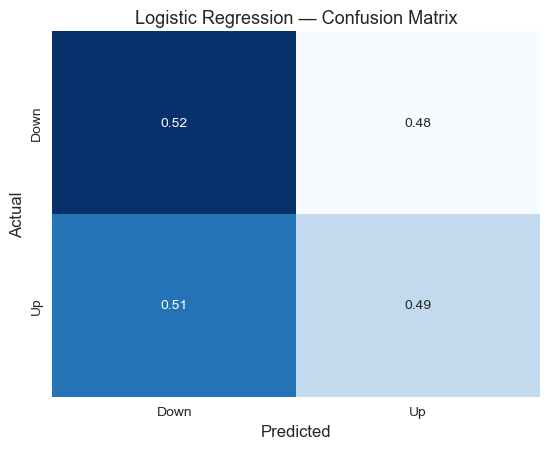

10:34:18 | INFO     | [END] Evaluate Logistic Regression (classification) in 0.8s
10:34:18 | INFO     | Rendering confusion matrix for Random Forest (CLS) ...
10:34:18 | INFO     | [START] Evaluate Random Forest (CLS) (classification)
10:34:19 | INFO     | Random Forest (CLS) — Acc: 0.5170 | Prec: 0.5065 | Rec: 0.3811 | F1: 0.4349 | AUC: 0.5210


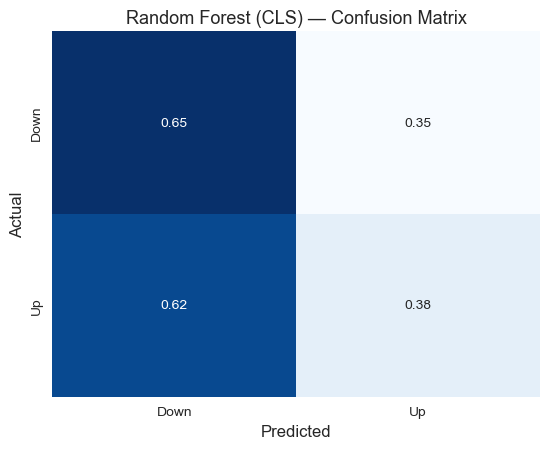

10:34:19 | INFO     | [END] Evaluate Random Forest (CLS) (classification) in 1.4s
10:34:19 | INFO     | Rendering confusion matrix for Decision Tree (CLS) ...
10:34:19 | INFO     | [START] Evaluate Decision Tree (CLS) (classification)
10:34:20 | INFO     | Decision Tree (CLS) — Acc: 0.5006 | Prec: 0.4882 | Rec: 0.4961 | F1: 0.4921 | AUC: 0.5004


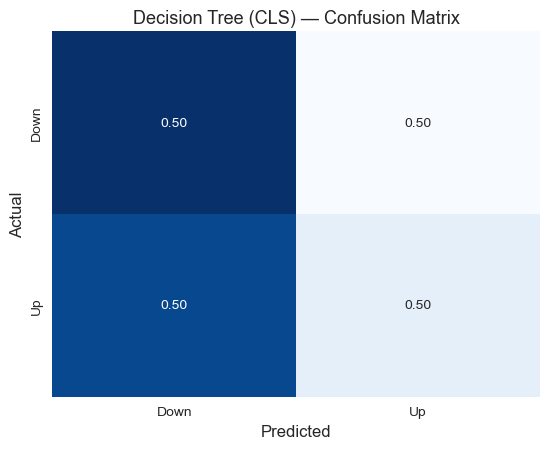

10:34:20 | INFO     | [END] Evaluate Decision Tree (CLS) (classification) in 0.5s
10:34:20 | INFO     | [END] Confusion matrices in 2.7s


In [16]:
# Confusion Matrices (Classification, Validation)

# Pre-reqs
_missing = [k for k in ("trained_models","X_valid_cls","y_valid_cls",
                        "evaluate_classifier","plot_confusion_matrix") if k not in globals()]
assert not _missing, f"Prereqs missing: {_missing}. Re-run prior blocks."

# Prefer trained models; fall back to registry if needed
cls_names = ["Logistic Regression", "Random Forest (CLS)", "Decision Tree (CLS)"]
models_cls = []
for name in cls_names:
    m = trained_models.get(name) if "trained_models" in globals() else None
    if m is None and "MODELS_CLASSIFICATION" in globals():
        m = MODELS_CLASSIFICATION.get(name)
    assert m is not None, f"Model not available: {name}"
    models_cls.append((name, m))

with step_timer("Confusion matrices"):
    for name, model in models_cls:
        logger.info("Rendering confusion matrix for %s ...", name)
        _ = evaluate_classifier(
            model=model,
            X_valid=X_valid_cls,
            y_valid=y_valid_cls,
            name=name,
            plot_cm=True  # draws the heatmap via helper
        )

10:34:20 | INFO     | [START] ROC curves
10:34:20 | INFO     | Logistic Regression ROC-AUC: 0.5065
10:34:21 | INFO     | Random Forest (CLS) ROC-AUC: 0.5210
10:34:21 | INFO     | Decision Tree (CLS) ROC-AUC: 0.5004


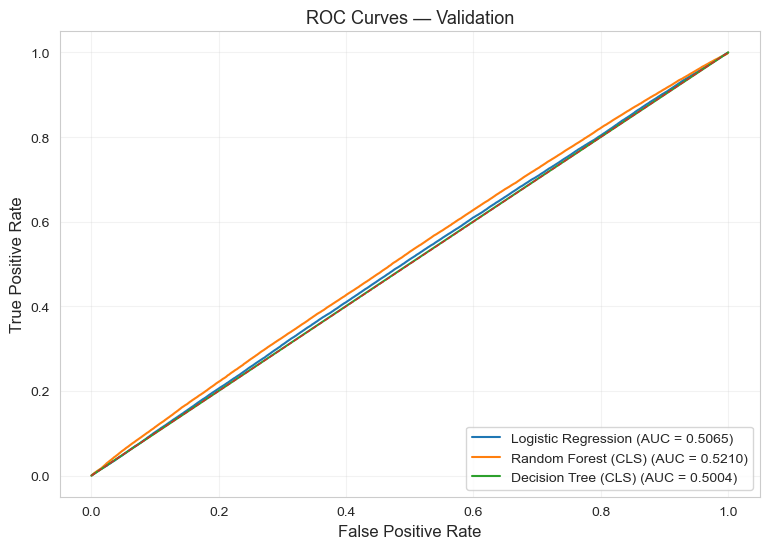

10:34:21 | INFO     | [END] ROC curves in 1.4s


In [17]:
# ROC Curves (Classification, Validation)

from sklearn.metrics import roc_curve, auc
# Pre-reqs
_missing = [k for k in ("X_valid_cls","y_valid_cls","step_timer") if k not in globals()]
assert not _missing, f"Prereqs missing: {_missing}. Re-run prior blocks."

# Prefer trained models; fallback to registry if needed
cls_names = ["Logistic Regression", "Random Forest (CLS)", "Decision Tree (CLS)"]
models_cls = []
for name in cls_names:
    m = (trained_models.get(name) if "trained_models" in globals() else None) \
        or (MODELS_CLASSIFICATION.get(name) if "MODELS_CLASSIFICATION" in globals() else None)
    assert m is not None, f"Model not available: {name}"
    models_cls.append((name, m))

with step_timer("ROC curves"):
    plt.figure(figsize=(7.8, 5.6))
    any_plotted = False
    for name, model in models_cls:
        if not hasattr(model, "predict_proba"):
            logger.info("Skipping ROC for %s (no predict_proba).", name)
            continue
        y_proba = model.predict_proba(X_valid_cls)[:, 1]
        fpr, tpr, _ = roc_curve(y_valid_cls, y_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.4f})")
        logger.info("%s ROC-AUC: %.4f", name, roc_auc)
        any_plotted = True

    # chance line + cosmetics
    plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1)
    plt.title("ROC Curves — Validation")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    if any_plotted:
        plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

10:34:21 | INFO     | Random seed set to 42.
10:34:21 | INFO     | [START] Regression Predicted vs Actual
10:34:21 | INFO     | Ridge (REG) — MAE: 0.001070 | RMSE: 0.003000 | R²: 0.0000 | Corr: 0.0136


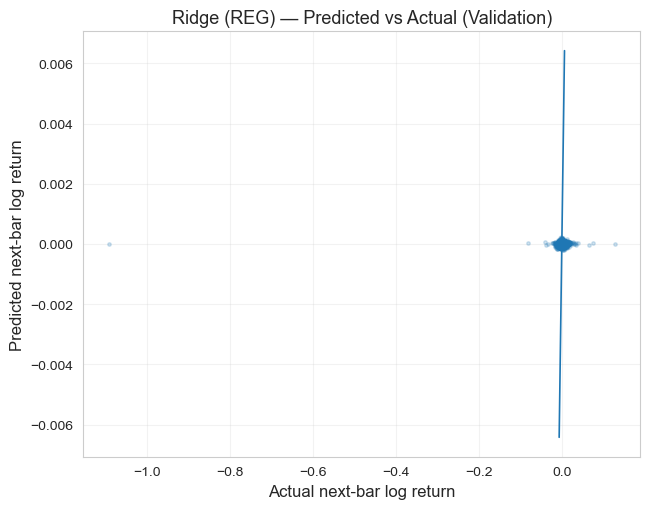

10:34:22 | INFO     | Random Forest (REG) — MAE: 0.001078 | RMSE: 0.003000 | R²: 0.0002 | Corr: 0.0521


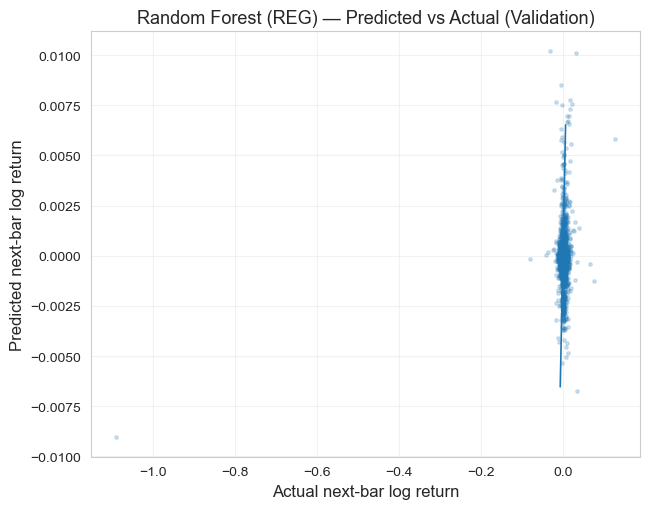

10:34:22 | INFO     | Elastic Net (REG) — MAE: 0.001071 | RMSE: 0.003000 | R²: -0.0001 | Corr: -0.0000


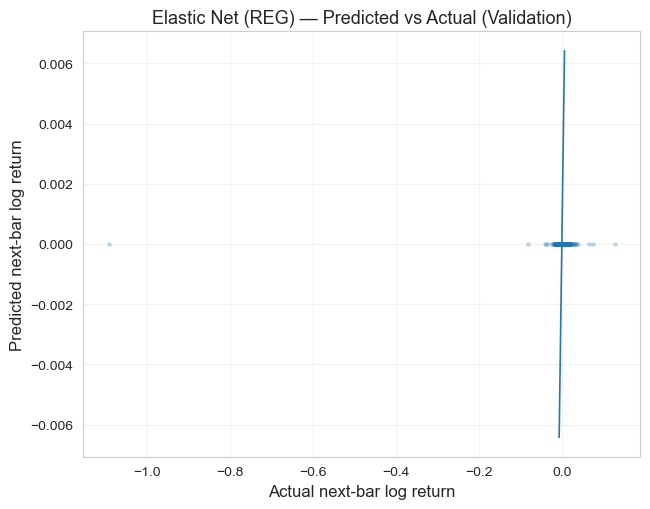

10:34:22 | INFO     | [END] Regression Predicted vs Actual in 1.2s


In [18]:
# Regression: Predicted vs Actual (Validation)

# Pre-reqs
_missing = [k for k in ("X_valid_reg","y_valid_reg","step_timer") if k not in globals()]
assert not _missing, f"Prereqs missing: {_missing}. Re-run prior blocks."

# Prefer trained models; fallback to registry if needed
reg_names = ["Ridge (REG)", "Random Forest (REG)", "Elastic Net (REG)"]
models_reg = []
for name in reg_names:
    m = (trained_models.get(name) if "trained_models" in globals() else None) \
        or (MODELS_REGRESSION.get(name) if "MODELS_REGRESSION" in globals() else None)
    assert m is not None, f"Model not available: {name}"
    models_reg.append((name, m))

# sampling for plotting speed
seed_everything(SEED)
n = len(y_valid_reg)
sample_n = min(50_000, n)
idx = np.random.choice(n, size=sample_n, replace=False)
y_true_sample = (y_valid_reg.iloc[idx].values
                 if hasattr(y_valid_reg, "iloc") else np.array(y_valid_reg)[idx])

with step_timer("Regression Predicted vs Actual"):
    for name, model in models_reg:
        # predict full validation, log metrics
        y_pred = model.predict(X_valid_reg)
        mae  = mean_absolute_error(y_valid_reg, y_pred)
        rmse = mean_squared_error(y_valid_reg, y_pred, squared=False)
        r2   = r2_score(y_valid_reg, y_pred)
        corr = np.corrcoef(np.asarray(y_valid_reg).ravel(), y_pred.ravel())[0, 1]
        logger.info("%s — MAE: %.6f | RMSE: %.6f | R²: %.4f | Corr: %.4f",
                    name, mae, rmse, r2, corr)

        # scatter (sampled) + y=x reference
        y_pred_sample = y_pred[idx]
        plt.figure(figsize=(6.6, 5.2))
        plt.scatter(y_true_sample, y_pred_sample, s=6, alpha=0.2)
        lim = np.quantile(np.abs(np.concatenate([y_true_sample, y_pred_sample])), 0.995)
        lim = float(max(lim, 1e-6))
        plt.plot([-lim, lim], [-lim, lim], linewidth=1.2)
        plt.title(f"{name} — Predicted vs Actual (Validation)")
        plt.xlabel("Actual next-bar log return")
        plt.ylabel("Predicted next-bar log return")
        plt.tight_layout()
        plt.show()

In [19]:
# Save artifacts
# - Saves: confusion matrices (CLS), ROC (CLS), Pred-vs-Actual (REG)
# - Writes JSON manifest pointing to latest metrics CSVs + figures

import json
from glob import glob

# Guards
_missing = [k for k in ("X_valid_cls","y_valid_cls","X_valid_reg","y_valid_reg","trained_models","step_timer")
            if k not in globals()]
assert not _missing, f"Prereqs missing: {_missing}. Re-run prior blocks."

FIG_DIR = "artifacts/figures"
MET_DIR = "artifacts/metrics"
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(MET_DIR, exist_ok=True)

def _latest(pattern):
    files = sorted(glob(os.path.join(MET_DIR, pattern)))
    return files[-1] if files else ""

with step_timer("Save figures and manifest"):
    ts = datetime.now().strftime("%Y%m%d_%H%M%S")

    # Confusion matrices (Validation)
    cm_paths = {}
    cls_names = ["Logistic Regression", "Random Forest (CLS)", "Decision Tree (CLS)"]
    for name in cls_names:
        model = trained_models.get(name)
        assert model is not None, f"Trained model not found: {name}"
        y_pred = model.predict(X_valid_cls)
        cm = confusion_matrix(y_valid_cls, y_pred)
        cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

        plt.figure(figsize=(5.8, 4.8))
        sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
                    xticklabels=["Down","Up"], yticklabels=["Down","Up"], cbar=False)
        plt.title(f"{name} — Confusion Matrix (Validation)")
        plt.xlabel("Predicted"); plt.ylabel("Actual")
        plt.tight_layout()
        path = os.path.join(FIG_DIR, f"week7_cm_{name.replace(' ','_').replace('(','').replace(')','')}_{ts}.png")
        plt.savefig(path, dpi=160, bbox_inches="tight"); plt.close()
        cm_paths[name] = path
        logger.info("Saved confusion matrix: %s", path)

    # ROC curves (Validation)
    roc_path = os.path.join(FIG_DIR, f"week7_roc_{ts}.png")
    plt.figure(figsize=(7.8, 5.6))
    any_plotted = False
    for name in cls_names:
        model = trained_models.get(name)
        if not hasattr(model, "predict_proba"):
            logger.info("Skipping ROC for %s (no predict_proba).", name)
            continue
        y_proba = model.predict_proba(X_valid_cls)[:, 1]
        fpr, tpr, _ = roc_curve(y_valid_cls, y_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.4f})")
        any_plotted = True
        logger.info("%s ROC-AUC: %.4f", name, roc_auc)
    plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1)
    plt.title("ROC Curves — Validation")
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    if any_plotted: plt.legend(loc="lower right")
    plt.tight_layout(); plt.savefig(roc_path, dpi=160, bbox_inches="tight"); plt.close()
    logger.info("Saved ROC figure: %s", roc_path)

    # Regression: Predicted vs Actual (Validation)
    reg_paths = {}
    reg_names = ["Ridge (REG)", "Random Forest (REG)", "Elastic Net (REG)"]

    # sample for speed
    seed_everything(SEED)
    n = len(y_valid_reg)
    sample_n = min(50_000, n)
    idx = np.random.choice(n, size=sample_n, replace=False)
    y_true_sample = (y_valid_reg.iloc[idx].values
                     if hasattr(y_valid_reg, "iloc") else np.array(y_valid_reg)[idx])

    for name in reg_names:
        model = trained_models.get(name)
        assert model is not None, f"Trained model not found: {name}"
        y_pred = model.predict(X_valid_reg)
        # log quick stats
        mae  = mean_absolute_error(y_valid_reg, y_pred)
        rmse = mean_squared_error(y_valid_reg, y_pred, squared=False)
        r2   = r2_score(y_valid_reg, y_pred)
        logger.info("%s — MAE: %.6f | RMSE: %.6f | R²: %.4f", name, mae, rmse, r2)

        # scatter + y=x
        y_pred_sample = y_pred[idx]
        plt.figure(figsize=(6.6, 5.2))
        plt.scatter(y_true_sample, y_pred_sample, s=6, alpha=0.2)
        lim = np.quantile(np.abs(np.concatenate([y_true_sample, y_pred_sample])), 0.995)
        lim = float(max(lim, 1e-6))
        plt.plot([-lim, lim], [-lim, lim], linewidth=1.2)
        plt.title(f"{name} — Predicted vs Actual (Validation)")
        plt.xlabel("Actual next-bar log return")
        plt.ylabel("Predicted next-bar log return")
        plt.tight_layout()
        path = os.path.join(FIG_DIR, f"week7_reg_scatter_{name.replace(' ','_').replace('(','').replace(')','')}_{ts}.png")
        plt.savefig(path, dpi=160, bbox_inches="tight"); plt.close()
        reg_paths[name] = path
        logger.info("Saved regression scatter: %s", path)

    # Latest metrics CSVs
    cls_csv = _latest("week7_task1_classification_*.csv")
    reg_csv = _latest("week7_task1_regression_*.csv")

    # Manifest
    manifest = {
        "timestamp": ts,
        "metrics_csv": {
            "classification": cls_csv,
            "regression": reg_csv
        },
        "figures": {
            "confusion_matrices": cm_paths,
            "roc": roc_path,
            "regression_scatter": reg_paths
        }
    }
    manifest_path = os.path.join("artifacts", f"week7_manifest_{ts}.json")
    with open(manifest_path, "w") as f:
        json.dump(manifest, f, indent=2)

    logger.info("Saved manifest: %s", manifest_path)

10:34:22 | INFO     | [START] Save figures and manifest


10:34:23 | INFO     | Saved confusion matrix: artifacts/figures/week7_cm_Logistic_Regression_20251015_103422.png
10:34:23 | INFO     | Saved confusion matrix: artifacts/figures/week7_cm_Random_Forest_CLS_20251015_103422.png
10:34:24 | INFO     | Saved confusion matrix: artifacts/figures/week7_cm_Decision_Tree_CLS_20251015_103422.png
10:34:24 | INFO     | Logistic Regression ROC-AUC: 0.5065
10:34:25 | INFO     | Random Forest (CLS) ROC-AUC: 0.5210
10:34:25 | INFO     | Decision Tree (CLS) ROC-AUC: 0.5004
10:34:25 | INFO     | Saved ROC figure: artifacts/figures/week7_roc_20251015_103422.png
10:34:25 | INFO     | Random seed set to 42.
10:34:25 | INFO     | Ridge (REG) — MAE: 0.001070 | RMSE: 0.003000 | R²: 0.0000
10:34:25 | INFO     | Saved regression scatter: artifacts/figures/week7_reg_scatter_Ridge_REG_20251015_103422.png
10:34:26 | INFO     | Random Forest (REG) — MAE: 0.001078 | RMSE: 0.003000 | R²: 0.0002
10:34:26 | INFO     | Saved regression scatter: artifacts/figures/week7_reg_

In [20]:
# Summary

from IPython.display import Markdown, display

def _fmt(v, nd=4):
    try: return ("{0:." + str(nd) + "f}").format(float(v))
    except Exception: return "NA"

def _last_manifest():
    files = sorted(glob("artifacts/week7_manifest_*.json"))
    return files[-1] if files else ""

with step_timer("Summary card"):
    # ensure result tables exist & build from dicts if needed
    try:
        df_cls
    except NameError:
        df_cls = metrics_to_df(results_classification) if 'results_classification' in globals() else pd.DataFrame()
    try:
        df_reg
    except NameError:
        df_reg = metrics_to_df(results_regression) if 'results_regression' in globals() else pd.DataFrame()

    # derive best models & metrics
    best_cls_name = best_reg_name = None
    cls_line = "No classification results available."
    reg_line = "No regression results available."

    if not df_cls.empty:
        if "roc_auc" not in df_cls.columns: df_cls["roc_auc"] = np.nan
        if "f1" not in df_cls.columns: df_cls["f1"] = np.nan
        metric_key = "roc_auc" if df_cls["roc_auc"].notna().any() else "f1"
        best_cls_name = df_cls[metric_key].idxmax()
        row = df_cls.loc[best_cls_name]
        cls_line = (
            f"Top classification model by {metric_key.upper()}: <b>{best_cls_name}</b> · "
            f"Accuracy {_fmt(row.get('accuracy'))}, Precision {_fmt(row.get('precision'))}, "
            f"Recall {_fmt(row.get('recall'))}, F1 {_fmt(row.get('f1'))}, "
            f"AUC {_fmt(row.get('roc_auc'))}."
        )

    if not df_reg.empty:
        for c in ["mae","rmse","r2"]:
            if c not in df_reg.columns: df_reg[c] = np.nan
        best_reg_name = df_reg["mae"].idxmin()
        row = df_reg.loc[best_reg_name]
        reg_line = (
            f"Top regression model by MAE: <b>{best_reg_name}</b> · "
            f"MAE {_fmt(row.get('mae'),6)}, RMSE {_fmt(row.get('rmse'),6)}, R² {_fmt(row.get('r2'))}."
        )

    # dataset context
    tmin_tr = df_train["timestamp"].min() if "timestamp" in df_train.columns else ""
    tmax_tr = df_train["timestamp"].max() if "timestamp" in df_train.columns else ""
    tmin_va = df_valid["timestamp"].min() if "timestamp" in df_valid.columns else ""
    tmax_va = df_valid["timestamp"].max() if "timestamp" in df_valid.columns else ""

    # manifest
    mani_path = _last_manifest()
    mani_note = f"Artifacts saved (see manifest: <code>{os.path.basename(mani_path)}</code>)." if mani_path else "Artifacts manifest not found."

    # Results
    para1 = (
        f"We trained baseline models on Week-6 features under a strict temporal split "
        f"(train: {tmin_tr} → {tmax_tr}; valid: {tmin_va} → {tmax_va}). "
        f"Data integrity checks passed (no duplicates; acceptable intra-day spacing), and all steps were timed and "
        f"logged. For <b>classification</b> (next-bar direction), models delivered near-chance performance "
        f"(ROC-AUC ≈ 0.50 overall), with marginal variation across algorithms. {cls_line}"
    )

    para2 = (
        f"For <b>regression</b> (next-bar log-return magnitude), absolute errors were small—as expected for 5-minute returns—"
        f"but explanatory power remained limited (R² ≈ 0). {reg_line} "
        f"These results constitute a clean, reproducible baseline. In Week-8 we will focus on threshold tuning and "
        f"probability calibration, window/feature variations for stronger signal, and cost-aware evaluation using the "
        f"saved probabilities/outputs. {mani_note}"
    )

    # render card
    md = f"""
<div style="
  border-radius:18px;
  padding:20px 22px;
  background-color:#fdfdfd;
  border:1px solid #cfd8dc;
  font-family:'Montserrat',sans-serif;
  line-height:1.6;
  color:#1a1a1a;
">
  <h4 style="color:#0044cc;margin:0 0 8px 0;">Baseline Training & Initial Evaluation (Summary)</h4>
  <p style="margin:0 0 10px 0;">{para1}</p>
  <p style="margin:0;">{para2}</p>
</div>
"""
    logger.info("Summary card generated.")
    display(Markdown(md))

10:34:27 | INFO     | [START] Summary card
10:34:27 | INFO     | Summary card generated.



<div style="
  border-radius:18px;
  padding:20px 22px;
  background-color:#fdfdfd;
  border:1px solid #cfd8dc;
  font-family:'Montserrat',sans-serif;
  line-height:1.6;
  color:#1a1a1a;
">
  <h4 style="color:#0044cc;margin:0 0 8px 0;">Baseline Training & Initial Evaluation (Summary)</h4>
  <p style="margin:0 0 10px 0;">We trained baseline models on Week-6 features under a strict temporal split (train: 2024-01-02 14:30:00+00:00 → 2024-03-14 19:55:00+00:00; valid: 2024-03-15 13:30:00+00:00 → 2024-03-28 19:55:00+00:00). Data integrity checks passed (no duplicates; acceptable intra-day spacing), and all steps were timed and logged. For <b>classification</b> (next-bar direction), models delivered near-chance performance (ROC-AUC ≈ 0.50 overall), with marginal variation across algorithms. Top classification model by ROC_AUC: <b>Random Forest (CLS)</b> · Accuracy 0.5170, Precision 0.5065, Recall 0.3811, F1 0.4349, AUC 0.5210.</p>
  <p style="margin:0;">For <b>regression</b> (next-bar log-return magnitude), absolute errors were small—as expected for 5-minute returns—but explanatory power remained limited (R² ≈ 0). Top regression model by MAE: <b>Ridge (REG)</b> · MAE 0.001100, RMSE 0.003000, R² 0.0000. These results constitute a clean, reproducible baseline. In Week-8 we will focus on threshold tuning and probability calibration, window/feature variations for stronger signal, and cost-aware evaluation using the saved probabilities/outputs. Artifacts saved (see manifest: <code>week7_manifest_20251015_103422.json</code>).</p>
</div>


10:34:27 | INFO     | [END] Summary card in 0.0s


In [21]:
with step_timer("Render performance and interpretation"):
    # Ensure tables exist (or rebuild from results_* dicts)
    try:
        df_cls_now, df_reg_now
    except NameError:
        df_cls_now, df_reg_now = _ensure_tables()

    # Build metric tables (HTML)
    cls_table_html = _html_metrics_table_cls(df_cls_now)
    reg_table_html = _html_metrics_table_reg(df_reg_now)

    # Top models + narrative
    best_cls_name = None
    best_reg_name = None

    if not df_cls_now.empty:
        if "roc_auc" not in df_cls_now.columns: df_cls_now["roc_auc"] = np.nan
        if "f1" not in df_cls_now.columns: df_cls_now["f1"] = np.nan
        metric_key = "roc_auc" if df_cls_now["roc_auc"].notna().any() else "f1"
        best_cls_name = df_cls_now[metric_key].idxmax()

    if not df_reg_now.empty:
        for c in ["mae","rmse","r2"]:
            if c not in df_reg_now.columns: df_reg_now[c] = np.nan
        best_reg_name = df_reg_now["mae"].idxmin()

    auc_vals = df_cls_now["roc_auc"].dropna().values if not df_cls_now.empty else np.array([])
    near_chance = (auc_vals.size > 0) and (np.nanmean(auc_vals) >= 0.49) and (np.nanmean(auc_vals) <= 0.51)
    cls_summary = (
        "near-chance direction performance (ROC-AUC ≈ 0.50)"
        if near_chance and not df_cls_now.empty
        else (f"direction performance led by {best_cls_name} (AUC {_fmt(df_cls_now.loc[best_cls_name,'roc_auc'])})"
              if not df_cls_now.empty else "no classification results recorded")
    )

    reg_r2_vals = df_reg_now["r2"].dropna().values if not df_reg_now.empty else np.array([])
    low_r2 = (reg_r2_vals.size > 0) and (np.nanmean(reg_r2_vals) < 0.05)
    reg_summary = (
        "very small absolute errors but low explained variance (R² ≈ 0)"
        if low_r2 and not df_reg_now.empty
        else (f"best by MAE: {best_reg_name} (MAE {_fmt6(df_reg_now.loc[best_reg_name,'mae'])})"
              if not df_reg_now.empty else "no regression results recorded")
    )

    # Class balance to tailor the metric justification
    p1 = None
    if "y" in df_train.columns:
        try: p1 = float(df_train["y"].mean())
        except Exception: p1 = None
    balanced = (p1 is not None) and (0.45 <= p1 <= 0.55)

    metric_just_cls = (
        "With roughly balanced classes, Accuracy and F1 are straightforward summaries; however, we rely on "
        "<b>ROC-AUC</b> as the primary comparator because it evaluates ranking without a fixed threshold."
        if balanced else
        "With class imbalance risk, <b>Precision</b>, <b>Recall</b>, and <b>F1</b> become more critical than raw Accuracy, "
        "while <b>ROC-AUC</b> remains a strong threshold-free comparator."
    )

    metric_just_reg = (
        "For magnitude prediction, <b>RMSE</b> and <b>MAE</b> quantify error scale on small 5-minute returns, while <b>R²</b> "
        "indicates explained variance. Near-zero R² here implies predictions cluster around the mean with limited signal."
        if low_r2 else
        "For magnitude prediction, <b>RMSE</b> and <b>MAE</b> quantify error scale; <b>R²</b> reflects variance explained."
    )

    # Compose card HTML
    perf_card_html = f"""
<div style="border-radius:18px;padding:20px 22px;background:#fdfdfd;border:1px solid #cfd8dc;
            font-family:'Montserrat',sans-serif;line-height:1.5;color:#1a1a1a;">
  <h4 style="color:#0044cc;margin:0 0 10px 0;">Performance & Initial Analysis</h4>

  <p style="margin:0 0 10px 0;">
    <b>Summary.</b> On the validation split, classifiers show {cls_summary}. Confusion matrices are largely symmetric and ROC curves
    lie close to the diagonal, indicating limited separability at a 5-minute horizon with the current features. For regression, models show {reg_summary},
    consistent with tiny short-horizon returns dominated by noise under this label definition.
  </p>

  <p style="margin:0 0 8px 0;"><b>Metric tables (exact values)</b></p>
  <div style="overflow-x:auto;">
    <div style="margin:6px 0 10px 0;">
      <div style="font-weight:600;margin-bottom:4px;">Classification</div>
      {cls_table_html}
    </div>
    <div style="margin:6px 0 0 0;">
      <div style="font-weight:600;margin-bottom:4px;">Regression</div>
      {reg_table_html}
    </div>
  </div>

  <p style="margin:12px 0 6px 0;"><b>Interpretation & metric choice.</b> {metric_just_cls} {metric_just_reg}</p>

  <p style="margin:6px 0 0 0;">
    <b>Candidates & next steps.</b> For direction, <i>{best_cls_name if best_cls_name else "the leading classifier"}</i> is the nominal leader but still near chance—making it a good baseline for
    <i>probability calibration</i> and <i>threshold tuning</i>. For magnitude, <i>{best_reg_name if best_reg_name else "the leading regressor"}</i> serves as the linear/non-linear baseline while we
    explore longer or regime-aware label windows and richer rolling features. We will also add a lightweight gradient-boosted baseline
    and conduct final evaluation to link scores to PnL.
  </p>
</div>
"""
    display(Markdown(perf_card_html))

10:34:27 | INFO     | [START] Render performance and interpretation



<div style="border-radius:18px;padding:20px 22px;background:#fdfdfd;border:1px solid #cfd8dc;
            font-family:'Montserrat',sans-serif;line-height:1.5;color:#1a1a1a;">
  <h4 style="color:#0044cc;margin:0 0 10px 0;">Performance & Initial Analysis</h4>

  <p style="margin:0 0 10px 0;">
    <b>Summary.</b> On the validation split, classifiers show near-chance direction performance (ROC-AUC ≈ 0.50). Confusion matrices are largely symmetric and ROC curves
    lie close to the diagonal, indicating limited separability at a 5-minute horizon with the current features. For regression, models show very small absolute errors but low explained variance (R² ≈ 0),
    consistent with tiny short-horizon returns dominated by noise under this label definition.
  </p>

  <p style="margin:0 0 8px 0;"><b>Metric tables (exact values)</b></p>
  <div style="overflow-x:auto;">
    <div style="margin:6px 0 10px 0;">
      <div style="font-weight:600;margin-bottom:4px;">Classification</div>
      <table style='border-collapse:separate;border-spacing:0;width:100%;'><thead><tr><th style='text-align:left;'>Model</th><th>Accuracy</th><th>Precision</th><th>Recall</th><th>F1</th><th>AUC</th></tr></thead><tbody><tr><td style='text-align:left;'>Random Forest (CLS)</td><td>0.5170</td><td>0.5065</td><td>0.3811</td><td>0.4349</td><td>0.5210</td></tr><tr><td style='text-align:left;'>Logistic Regression</td><td>0.5060</td><td>0.4935</td><td>0.4897</td><td>0.4916</td><td>0.5065</td></tr><tr><td style='text-align:left;'>Decision Tree (CLS)</td><td>0.5006</td><td>0.4882</td><td>0.4961</td><td>0.4921</td><td>0.5004</td></tr></tbody></table>
    </div>
    <div style="margin:6px 0 0 0;">
      <div style="font-weight:600;margin-bottom:4px;">Regression</div>
      <table style='border-collapse:separate;border-spacing:0;width:100%;'><thead><tr><th style='text-align:left;'>Model</th><th>MAE</th><th>RMSE</th><th>R²</th></tr></thead><tbody><tr><td style='text-align:left;'>Ridge (REG)</td><td>0.001100</td><td>0.003000</td><td>0.0000</td></tr><tr><td style='text-align:left;'>Random Forest (REG)</td><td>0.001100</td><td>0.003000</td><td>0.0002</td></tr><tr><td style='text-align:left;'>Elastic Net (REG)</td><td>0.001100</td><td>0.003000</td><td>-0.0001</td></tr></tbody></table>
    </div>
  </div>

  <p style="margin:12px 0 6px 0;"><b>Interpretation & metric choice.</b> With roughly balanced classes, Accuracy and F1 are straightforward summaries; however, we rely on <b>ROC-AUC</b> as the primary comparator because it evaluates ranking without a fixed threshold. For magnitude prediction, <b>RMSE</b> and <b>MAE</b> quantify error scale on small 5-minute returns, while <b>R²</b> indicates explained variance. Near-zero R² here implies predictions cluster around the mean with limited signal.</p>

  <p style="margin:6px 0 0 0;">
    <b>Candidates & next steps.</b> For direction, <i>Random Forest (CLS)</i> is the nominal leader but still near chance—making it a good baseline for
    <i>probability calibration</i> and <i>threshold tuning</i>. For magnitude, <i>Ridge (REG)</i> serves as the linear/non-linear baseline while we
    explore longer or regime-aware label windows and richer rolling features. We will also add a lightweight gradient-boosted baseline
    and conduct final evaluation to link scores to PnL.
  </p>
</div>


10:34:27 | INFO     | [END] Render performance and interpretation in 0.0s


### Model Optimization (Classification)

In [23]:
# Initialize directories in the existing artifacts layout.
from pathlib import Path

CV_DIR = Path("artifacts/cv")
PRED_DIR = Path("artifacts/predictions")

CV_DIR.mkdir(parents=True, exist_ok=True)
PRED_DIR.mkdir(parents=True, exist_ok=True)

try:
    _fig = FIG_DIR  # should be "artifacts/figures"
    _met = MET_DIR  # should be "artifacts/metrics"
    logger.info(f"FIG_DIR={_fig}  MET_DIR={_met}")
except NameError:
    logger.info("FIG_DIR/MET_DIR not found in scope yet.")

logger.info("Classification: initialized CV and predictions directories under artifacts/")


10:36:36 | INFO     | FIG_DIR=artifacts/figures  MET_DIR=artifacts/metrics
10:36:36 | INFO     | Classification: initialized CV and predictions directories under artifacts/


#### CV subset and fold manifest (classification)

In [33]:
#### Helpers: CV manifests (classification)
import logging
from pathlib import Path
from typing import List, Tuple, Optional
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

logger = logging.getLogger("week8")

def _require_cols(df: pd.DataFrame, cols: List[str], ctx: str):
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise AssertionError(f"{ctx}: missing columns {missing}")

def _as_year_filtered(df: pd.DataFrame, year: Optional[int]) -> pd.DataFrame:
    # Parse and drop timezone cleanly to avoid warnings in to_period()
    ts = pd.to_datetime(df["timestamp"], errors="coerce", utc=True)
    try:
        # if tz-aware, remove tz
        ts = ts.dt.tz_localize(None)
    except Exception:
        # if already tz-naive, ignore
        pass
    out = df.copy()
    out["timestamp"] = ts
    if year is not None:
        out = out.loc[out["timestamp"].dt.year == year].copy()
    return out

def _fold_rows_from_periods(periods: list[pd.Period], min_train_windows: int) -> pd.DataFrame:
    if len(periods) < (min_train_windows + 1):
        raise AssertionError(
            f"Not enough distinct periods for expanding CV. "
            f"Found {len(periods)} period(s) with min_train_windows={min_train_windows}."
        )
    rows = []
    for i in range(min_train_windows - 1, len(periods) - 1):
        train_start = periods[0]
        train_end   = periods[i]
        val_period  = periods[i + 1]
        rows.append({
            "fold": len(rows) + 1,
            "train_start": train_start.start_time.floor("s").isoformat(),
            "train_end":   train_end.end_time.floor("s").isoformat(),
            "val_start":   val_period.start_time.floor("s").isoformat(),
            "val_end":     val_period.end_time.floor("s").isoformat(),
        })
    return pd.DataFrame(rows)

def build_cv_manifests_cls(
    df_train: pd.DataFrame,
    df_valid: pd.DataFrame,
    year: Optional[int] = None,          # None => use whatever span exists
    target_n_symbols: int = 100,
    cv_dir: Path = Path("artifacts/cv")
) -> Tuple[Path, Path]:
    """
    Saves:
      - artifacts/cv/week7_cls_cv_folds.csv
      - artifacts/cv/week7_cls_tuning_symbols.csv
    """
    _require_cols(df_train, ["timestamp", "symbol"], "df_train")
    _require_cols(df_valid, ["timestamp", "symbol"], "df_valid")

    cv_dir.mkdir(parents=True, exist_ok=True)

    df_cv = pd.concat([df_train.copy(), df_valid.copy()], ignore_index=True)
    df_cv = _as_year_filtered(df_cv, year).sort_values(["timestamp", "symbol"])

    # Prefer MONTHLY folds when we have enough months (>=4 for 3-month train + 1-month val)
    months = [pd.Period(m, freq="M") for m in df_cv["timestamp"].dt.to_period("M").unique()]
    if len(months) >= 4:
        months_use = months[:8] if len(months) >= 8 else months
        folds_df = _fold_rows_from_periods(months_use, min_train_windows=3)
        mode = "monthly"
    else:
        # Fallback: ISO weeks (Monday-anchored), needs >=3 weeks total
        weeks = [pd.Period(w, freq="W-MON") for w in df_cv["timestamp"].dt.to_period("W-MON").unique()]
        folds_df = _fold_rows_from_periods(weeks, min_train_windows=2)
        mode = "weekly"

    symbols = sorted(df_cv["symbol"].dropna().unique().tolist())
    if not symbols:
        raise AssertionError("No symbols found in the available span for df_train/df_valid.")

    step = max(1, len(symbols) // target_n_symbols)
    tuning_symbols = symbols[::step][:target_n_symbols]

    cv_folds_path = cv_dir / "week7_cls_cv_folds.csv"
    tuning_symbols_path = cv_dir / "week7_cls_tuning_symbols.csv"
    folds_df.to_csv(cv_folds_path, index=False)
    pd.DataFrame({"symbol": tuning_symbols}).to_csv(tuning_symbols_path, index=False)

    logger.info("CV mode=%s, folds=%d -> %s", mode, len(folds_df), cv_folds_path)
    logger.info("Tuning symbols -> %s (selected %d of %d; step=%d)",
                tuning_symbols_path, len(tuning_symbols), len(symbols), step)
    return cv_folds_path, tuning_symbols_path


In [34]:
#### Build CV subset and fold manifest (classification)

from pathlib import Path

cv_folds_path, tuning_symbols_path = build_cv_manifests_cls(
    df_train=df_train,
    df_valid=df_valid,
    year=None,                 # auto-detect span; monthly if >=4 months else weekly
    target_n_symbols=100,
    cv_dir=Path("artifacts/cv")
)


10:56:14 | INFO     | CV mode=weekly, folds=11 -> artifacts/cv/week7_cls_cv_folds.csv
10:56:14 | INFO     | Tuning symbols -> artifacts/cv/week7_cls_tuning_symbols.csv (selected 100 of 500; step=5)


In [35]:
import json
import logging
from pathlib import Path
from typing import Dict, List, Tuple
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

def _load_cv_manifests(cv_folds_csv: Path, tuning_symbols_csv: Path) -> Tuple[pd.DataFrame, List[str]]:
    folds = pd.read_csv(cv_folds_csv)
    for c in ("train_start","train_end","val_start","val_end"):
        folds[c] = pd.to_datetime(folds[c], utc=True).dt.tz_localize(None)
    tuning = pd.read_csv(tuning_symbols_csv)["symbol"].dropna().astype(str).tolist()
    return folds, tuning

def _df_cv_concat(df_train: pd.DataFrame, df_valid: pd.DataFrame) -> pd.DataFrame:
    df = pd.concat([df_train.copy(), df_valid.copy()], ignore_index=True)
    ts = pd.to_datetime(df["timestamp"], utc=True, errors="coerce").dt.tz_localize(None)
    df = df.assign(timestamp=ts)
    return df.sort_values(["timestamp","symbol"])

def _subset_by_period(df: pd.DataFrame, start, end, symbols: List[str]) -> pd.DataFrame:
    m = (df["timestamp"] >= start) & (df["timestamp"] <= end) & (df["symbol"].isin(symbols))
    return df.loc[m].copy()

def _model_registry(seed: int = 42) -> Dict[str, object]:
    return {
        "logreg": LogisticRegression(max_iter=1000, n_jobs=None, solver="lbfgs"),
        "tree":   DecisionTreeClassifier(random_state=seed),
        "rf":     RandomForestClassifier(
                    n_estimators=200, max_depth=None, min_samples_leaf=1,
                    max_features="sqrt", n_jobs=-1, random_state=seed)
    }

def _params_to_str(est) -> str:
    try:
        p = {k: v for k, v in est.get_params().items() if k in ("C","max_depth","min_samples_leaf","n_estimators","max_features","solver")}
        return json.dumps(p, sort_keys=True)
    except Exception:
        return "{}"

def run_cls_cv_baselines(
    df_train: pd.DataFrame,
    df_valid: pd.DataFrame,
    cv_folds_csv: Path,
    tuning_symbols_csv: Path,
    out_csv: Path
) -> Path:
    """
    For each CV fold:
      - build X/y matrices (classification) from df subsets
      - fit untuned models (logreg / tree / rf)
      - evaluate on validation
      - append fold-level metrics to out_csv
    """
    with step_timer("Baseline CV (classification)"):
        folds, tuning_symbols = _load_cv_manifests(cv_folds_csv, tuning_symbols_csv)
        df_cv = _df_cv_concat(df_train, df_valid)
        feature_cols = get_feature_columns(df_cv)

        rows: List[Dict] = []
        models = _model_registry()
        for _, row in folds.iterrows():
            fold_id = int(row["fold"])
            tr = _subset_by_period(df_cv, row["train_start"], row["train_end"], tuning_symbols)
            va = _subset_by_period(df_cv, row["val_start"], row["val_end"], tuning_symbols)

            # class balance log (validation)
            if "y" in va.columns and len(va) > 0:
                pos_rate = (va["y"] > 0).mean()
                logger.info("Fold %d | val size=%d | pos_rate=%.4f", fold_id, len(va), pos_rate)

            # Build matrices with your existing helper
            X_tr, y_tr, X_va, y_va = prepare_classification_matrices(tr, va, feature_cols)

            for name, est in models.items():
                mdl = fit_model(est, X_tr, y_tr, name=f"{name}-fold{fold_id}")
                m = evaluate_classifier(mdl, X_va, y_va, name=f"{name}-fold{fold_id}", plot_cm=False)
                rows.append({
                    "fold": fold_id,
                    "model": name,
                    "params": _params_to_str(est),
                    "roc_auc": m.get("roc_auc"),
                    "accuracy": m.get("accuracy"),
                    "precision": m.get("precision"),
                    "recall": m.get("recall"),
                    "f1": m.get("f1")
                })

        df_out = pd.DataFrame(rows).sort_values(["model","fold"]).reset_index(drop=True)
        out_csv.parent.mkdir(parents=True, exist_ok=True)
        df_out.to_csv(out_csv, index=False)
        logger.info("Saved baseline CV metrics -> %s", out_csv)
        return out_csv


In [36]:
ts_tag = pd.Timestamp.utcnow().strftime("%Y%m%d_%H%M%S")
cv_folds_csv = Path("artifacts/cv/week7_cls_cv_folds.csv")
tuning_symbols_csv = Path("artifacts/cv/week7_cls_tuning_symbols.csv")
out_csv = Path(MET_DIR) / f"week7_cls_cv_baselines_{ts_tag}.csv"

_ = run_cls_cv_baselines(
    df_train=df_train,
    df_valid=df_valid,
    cv_folds_csv=cv_folds_csv,
    tuning_symbols_csv=tuning_symbols_csv,
    out_csv=out_csv
)

10:59:34 | INFO     | [START] Baseline CV (classification)
10:59:35 | INFO     | Fold 1 | val size=32814 | pos_rate=0.5000
10:59:35 | INFO     | [START] Prepare matrices (classification)
10:59:35 | INFO     | X_train (CLS) dtype mix: {'float64': 15, 'bool': 5, 'int64': 2}
10:59:35 | INFO     | X_valid (CLS) dtype mix: {'float64': 15, 'bool': 5, 'int64': 2}
10:59:35 | INFO     | CLS matrices ready — X_train:(57502, 22)  X_valid:(32814, 22)
10:59:35 | INFO     | [END] Prepare matrices (classification) in 0.0s
10:59:35 | INFO     | [START] Fit logreg-fold1
10:59:36 | INFO     | [END] Fit logreg-fold1 in 0.9s
10:59:36 | INFO     | [START] Evaluate logreg-fold1 (classification)
10:59:36 | INFO     | logreg-fold1 — Acc: 0.4988 | Prec: 0.4981 | Rec: 0.2971 | F1: 0.3722 | AUC: 0.4999
10:59:36 | INFO     | [END] Evaluate logreg-fold1 (classification) in 0.1s
10:59:36 | INFO     | [START] Fit tree-fold1
10:59:37 | INFO     | [END] Fit tree-fold1 in 1.5s
10:59:37 | INFO     | [START] Evaluate tre

In [37]:
import json
import logging
from pathlib import Path
from typing import Dict, List, Tuple
import pandas as pd
from sklearn.linear_model import LogisticRegression

logger = logging.getLogger("week8")

# Reusing helpers defined earlier in this notebook:
# - _load_cv_manifests(cv_folds_csv, tuning_symbols_csv)
# - _df_cv_concat(df_train, df_valid)
# - _subset_by_period(df, start, end, symbols)
# - get_feature_columns(df)
# - prepare_classification_matrices(df_train, df_valid, feature_cols)
# - fit_model(model, X, y, name)
# - evaluate_classifier(model, X_valid, y_valid, name, plot_cm=False)

def run_cls_grid_logreg(
    df_train: pd.DataFrame,
    df_valid: pd.DataFrame,
    cv_folds_csv: Path,
    tuning_symbols_csv: Path,
    out_csv: Path,
    C_grid: List[float] = (0.01, 0.1, 1.0, 10.0),
    seed: int = 42
) -> Path:
    """
    Expanding CV (per manifest) over a C grid. Saves fold-level metrics to out_csv.
    """
    with step_timer("Grid CV (classification) — LogisticRegression"):
        folds, tuning_symbols = _load_cv_manifests(cv_folds_csv, tuning_symbols_csv)
        df_cv = _df_cv_concat(df_train, df_valid)
        feature_cols = get_feature_columns(df_cv)

        rows: List[Dict] = []
        for _, row in folds.iterrows():
            fold_id = int(row["fold"])
            tr = _subset_by_period(df_cv, row["train_start"], row["train_end"], tuning_symbols)
            va = _subset_by_period(df_cv, row["val_start"], row["val_end"], tuning_symbols)

            X_tr, y_tr, X_va, y_va = prepare_classification_matrices(tr, va, feature_cols)

            for C in C_grid:
                est = LogisticRegression(C=C, solver="lbfgs", max_iter=1000)
                mdl = fit_model(est, X_tr, y_tr, name=f"logreg-C{C}-fold{fold_id}")
                m = evaluate_classifier(mdl, X_va, y_va, name=f"logreg-C{C}-fold{fold_id}", plot_cm=False)

                rows.append({
                    "fold": fold_id,
                    "model": "logreg",
                    "params": json.dumps({"C": C}),
                    "roc_auc": m.get("roc_auc"),
                    "accuracy": m.get("accuracy"),
                    "precision": m.get("precision"),
                    "recall": m.get("recall"),
                    "f1": m.get("f1")
                })

        df_out = pd.DataFrame(rows).sort_values(["fold","model"]).reset_index(drop=True)
        out_csv.parent.mkdir(parents=True, exist_ok=True)
        df_out.to_csv(out_csv, index=False)
        logger.info("Saved grid CV (logreg) -> %s", out_csv)
        return out_csv

def _select_best_params_logreg(cv_csv: Path) -> Dict:
    """
    Choose best C by mean ROC-AUC across folds; tie-break by mean F1, then Accuracy.
    Returns {"C": <value>}.
    """
    df = pd.read_csv(cv_csv)
    agg = (df
           .assign(C=df["params"].apply(lambda s: json.loads(s)["C"]))
           .groupby("C", as_index=False)
           .agg(roc_auc=("roc_auc","mean"),
                f1=("f1","mean"),
                accuracy=("accuracy","mean"))
           .sort_values(["roc_auc","f1","accuracy"], ascending=[False, False, False]))
    best = {"C": float(agg.iloc[0]["C"])}
    logger.info("Best logreg params (CV mean): %s", best)
    return best

def _update_best_params_json(best_params_path: Path, model_key: str, params: Dict):
    best_params_path.parent.mkdir(parents=True, exist_ok=True)
    if best_params_path.exists():
        try:
            data = json.loads(best_params_path.read_text())
        except Exception:
            data = {}
    else:
        data = {}
    data[model_key] = params
    best_params_path.write_text(json.dumps(data, indent=2))
    logger.info("Updated best params JSON -> %s", best_params_path)

#### Logistic Regression (classification) — execute grid CV & pick best C

In [38]:
from pathlib import Path
import pandas as pd

ts_tag = pd.Timestamp.utcnow().strftime("%Y%m%d_%H%M%S")
cv_folds_csv = Path("artifacts/cv/week7_cls_cv_folds.csv")
tuning_symbols_csv = Path("artifacts/cv/week7_cls_tuning_symbols.csv")

logreg_cv_csv = Path(MET_DIR) / f"week7_cls_cv_grid_logreg_{ts_tag}.csv"
best_params_json = Path(MET_DIR) / "week7_cls_best_params.json"

_ = run_cls_grid_logreg(
    df_train=df_train,
    df_valid=df_valid,
    cv_folds_csv=cv_folds_csv,
    tuning_symbols_csv=tuning_symbols_csv,
    out_csv=logreg_cv_csv,
    C_grid=[0.01, 0.1, 1.0, 10.0]
)

best_logreg = _select_best_params_logreg(logreg_cv_csv)
_update_best_params_json(best_params_json, model_key="logreg", params=best_logreg)

11:12:51 | INFO     | [START] Grid CV (classification) — LogisticRegression
11:12:52 | INFO     | [START] Prepare matrices (classification)
11:12:52 | INFO     | X_train (CLS) dtype mix: {'float64': 15, 'bool': 5, 'int64': 2}
11:12:52 | INFO     | X_valid (CLS) dtype mix: {'float64': 15, 'bool': 5, 'int64': 2}
11:12:52 | INFO     | CLS matrices ready — X_train:(57502, 22)  X_valid:(32814, 22)
11:12:52 | INFO     | [END] Prepare matrices (classification) in 0.0s
11:12:52 | INFO     | [START] Fit logreg-C0.01-fold1
11:12:54 | INFO     | [END] Fit logreg-C0.01-fold1 in 1.5s
11:12:54 | INFO     | [START] Evaluate logreg-C0.01-fold1 (classification)
11:12:54 | INFO     | logreg-C0.01-fold1 — Acc: 0.4988 | Prec: 0.4980 | Rec: 0.2936 | F1: 0.3695 | AUC: 0.5001
11:12:54 | INFO     | [END] Evaluate logreg-C0.01-fold1 (classification) in 0.1s
11:12:54 | INFO     | [START] Fit logreg-C0.1-fold1
11:12:55 | INFO     | [END] Fit logreg-C0.1-fold1 in 1.1s
11:12:55 | INFO     | [START] Evaluate logreg

In [39]:
import json
import logging
from pathlib import Path
from typing import Dict, List
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

logger = logging.getLogger("week8")

def run_cls_grid_rf(
    df_train: pd.DataFrame,
    df_valid: pd.DataFrame,
    cv_folds_csv: Path,
    tuning_symbols_csv: Path,
    out_csv: Path,
    n_estimators_grid: List[int] = (200, 400),
    max_depth_grid: List[int | None] = (None, 8, 12, 16),
    min_samples_leaf_grid: List[int] = (1, 5),
    seed: int = 42
) -> Path:
    """
    Expanding CV (per manifest) over RF grid. Saves fold-level metrics to out_csv.
    """
    with step_timer("Grid CV (classification) — RandomForestClassifier"):
        folds, tuning_symbols = _load_cv_manifests(cv_folds_csv, tuning_symbols_csv)
        df_cv = _df_cv_concat(df_train, df_valid)
        feature_cols = get_feature_columns(df_cv)

        rows: List[Dict] = []
        for _, row in folds.iterrows():
            fold_id = int(row["fold"])
            tr = _subset_by_period(df_cv, row["train_start"], row["train_end"], tuning_symbols)
            va = _subset_by_period(df_cv, row["val_start"], row["val_end"], tuning_symbols)

            X_tr, y_tr, X_va, y_va = prepare_classification_matrices(tr, va, feature_cols)

            for n in n_estimators_grid:
                for d in max_depth_grid:
                    for leaf in min_samples_leaf_grid:
                        est = RandomForestClassifier(
                            n_estimators=n,
                            max_depth=d,
                            min_samples_leaf=leaf,
                            max_features="sqrt",
                            n_jobs=-1,
                            random_state=seed
                        )
                        mdl = fit_model(est, X_tr, y_tr, name=f"rf-{n}-{d}-{leaf}-fold{fold_id}")
                        m = evaluate_classifier(mdl, X_va, y_va, name=f"rf-{n}-{d}-{leaf}-fold{fold_id}", plot_cm=False)

                        rows.append({
                            "fold": fold_id,
                            "model": "rf",
                            "params": json.dumps({
                                "n_estimators": int(n),
                                "max_depth": (None if d is None else int(d)),
                                "min_samples_leaf": int(leaf),
                                "max_features": "sqrt"
                            }),
                            "roc_auc": m.get("roc_auc"),
                            "accuracy": m.get("accuracy"),
                            "precision": m.get("precision"),
                            "recall": m.get("recall"),
                            "f1": m.get("f1")
                        })

        df_out = pd.DataFrame(rows).sort_values(["fold","model"]).reset_index(drop=True)
        out_csv.parent.mkdir(parents=True, exist_ok=True)
        df_out.to_csv(out_csv, index=False)
        logger.info("Saved grid CV (rf) -> %s", out_csv)
        return out_csv

def _select_best_params_rf(cv_csv: Path) -> Dict:
    """
    Choose best RF config by mean ROC-AUC across folds; tie-break by mean F1, then Accuracy.
    Returns a params dict suitable for estimator construction.
    """
    df = pd.read_csv(cv_csv)
    # parse params JSON per row
    P = df["params"].apply(json.loads)
    df = pd.concat([df.drop(columns=["params"]).reset_index(drop=True),
                    pd.json_normalize(P).reset_index(drop=True)], axis=1)

    agg = (df.groupby(["n_estimators","max_depth","min_samples_leaf","max_features"], as_index=False)
             .agg(roc_auc=("roc_auc","mean"),
                  f1=("f1","mean"),
                  accuracy=("accuracy","mean"))
             .sort_values(["roc_auc","f1","accuracy"], ascending=[False, False, False]))
    best_row = agg.iloc[0].to_dict()
    best = {
        "n_estimators": int(best_row["n_estimators"]),
        "max_depth": None if pd.isna(best_row["max_depth"]) else int(best_row["max_depth"]),
        "min_samples_leaf": int(best_row["min_samples_leaf"]),
        "max_features": str(best_row["max_features"])
    }
    logger.info("Best RF params (CV mean): %s", best)
    return best

def _update_best_params_json(best_params_path: Path, model_key: str, params: Dict):
    best_params_path.parent.mkdir(parents=True, exist_ok=True)
    if best_params_path.exists():
        try:
            data = json.loads(best_params_path.read_text())
        except Exception:
            data = {}
    else:
        data = {}
    data[model_key] = params
    best_params_path.write_text(json.dumps(data, indent=2))
    logger.info("Updated best params JSON -> %s", best_params_path)


#### Random Forest (classification) — execute grid CV & pick best

In [40]:
from pathlib import Path
import pandas as pd

ts_tag = pd.Timestamp.utcnow().strftime("%Y%m%d_%H%M%S")
cv_folds_csv = Path("artifacts/cv/week7_cls_cv_folds.csv")
tuning_symbols_csv = Path("artifacts/cv/week7_cls_tuning_symbols.csv")

rf_cv_csv = Path(MET_DIR) / f"week7_cls_cv_grid_rf_{ts_tag}.csv"
best_params_json = Path(MET_DIR) / "week7_cls_best_params.json"

_ = run_cls_grid_rf(
    df_train=df_train,
    df_valid=df_valid,
    cv_folds_csv=cv_folds_csv,
    tuning_symbols_csv=tuning_symbols_csv,
    out_csv=rf_cv_csv,
    n_estimators_grid=[200, 400],
    max_depth_grid=[None, 8, 12, 16],
    min_samples_leaf_grid=[1, 5]
)

best_rf = _select_best_params_rf(rf_cv_csv)
_update_best_params_json(best_params_json, model_key="rf", params=best_rf)


11:21:02 | INFO     | [START] Grid CV (classification) — RandomForestClassifier
11:21:03 | INFO     | [START] Prepare matrices (classification)
11:21:03 | INFO     | X_train (CLS) dtype mix: {'float64': 15, 'bool': 5, 'int64': 2}
11:21:03 | INFO     | X_valid (CLS) dtype mix: {'float64': 15, 'bool': 5, 'int64': 2}
11:21:03 | INFO     | CLS matrices ready — X_train:(57502, 22)  X_valid:(32814, 22)
11:21:03 | INFO     | [END] Prepare matrices (classification) in 0.0s
11:21:03 | INFO     | [START] Fit rf-200-None-1-fold1
11:21:10 | INFO     | [END] Fit rf-200-None-1-fold1 in 7.2s
11:21:10 | INFO     | [START] Evaluate rf-200-None-1-fold1 (classification)
11:21:11 | INFO     | rf-200-None-1-fold1 — Acc: 0.5030 | Prec: 0.5036 | Rec: 0.4255 | F1: 0.4613 | AUC: 0.5091
11:21:11 | INFO     | [END] Evaluate rf-200-None-1-fold1 (classification) in 0.5s
11:21:11 | INFO     | [START] Fit rf-200-None-5-fold1
11:21:17 | INFO     | [END] Fit rf-200-None-5-fold1 in 6.5s
11:21:17 | INFO     | [START] Ev

#### Decision Tree (classification) — grid CV

In [42]:
import json
import logging
from pathlib import Path
from typing import Dict, List
import pandas as pd
from sklearn.tree import DecisionTreeClassifier

logger = logging.getLogger("week8")

# Reuse earlier helpers:
# _load_cv_manifests, _df_cv_concat, _subset_by_period,
# get_feature_columns, prepare_classification_matrices,
# fit_model, evaluate_classifier

def run_cls_grid_tree(
    df_train: pd.DataFrame,
    df_valid: pd.DataFrame,
    cv_folds_csv: Path,
    tuning_symbols_csv: Path,
    out_csv: Path,
    max_depth_grid: List[int] = (3, 5, 8, 12, 16),
    min_samples_leaf_grid: List[int] = (1, 5, 10),
    seed: int = 42
) -> Path:
    """
    Expanding CV (per manifest) over DecisionTree grid. Saves fold-level metrics to out_csv.
    """
    with step_timer("Grid CV (classification) — DecisionTreeClassifier"):
        folds, tuning_symbols = _load_cv_manifests(cv_folds_csv, tuning_symbols_csv)
        df_cv = _df_cv_concat(df_train, df_valid)
        feature_cols = get_feature_columns(df_cv)

        rows: List[Dict] = []
        for _, row in folds.iterrows():
            fold_id = int(row["fold"])
            tr = _subset_by_period(df_cv, row["train_start"], row["train_end"], tuning_symbols)
            va = _subset_by_period(df_cv, row["val_start"], row["val_end"], tuning_symbols)

            X_tr, y_tr, X_va, y_va = prepare_classification_matrices(tr, va, feature_cols)

            for d in max_depth_grid:
                for leaf in min_samples_leaf_grid:
                    est = DecisionTreeClassifier(
                        max_depth=int(d),
                        min_samples_leaf=int(leaf),
                        random_state=seed
                    )
                    mdl = fit_model(est, X_tr, y_tr, name=f"tree-d{d}-leaf{leaf}-fold{fold_id}")
                    m = evaluate_classifier(mdl, X_va, y_va, name=f"tree-d{d}-leaf{leaf}-fold{fold_id}", plot_cm=False)

                    rows.append({
                        "fold": fold_id,
                        "model": "tree",
                        "params": json.dumps({
                            "max_depth": int(d),
                            "min_samples_leaf": int(leaf)
                        }),
                        "roc_auc": m.get("roc_auc"),
                        "accuracy": m.get("accuracy"),
                        "precision": m.get("precision"),
                        "recall": m.get("recall"),
                        "f1": m.get("f1")
                    })

        df_out = pd.DataFrame(rows).sort_values(["fold","model"]).reset_index(drop=True)
        out_csv.parent.mkdir(parents=True, exist_ok=True)
        df_out.to_csv(out_csv, index=False)
        logger.info("Saved grid CV (tree) -> %s", out_csv)
        return out_csv

def _select_best_params_tree(cv_csv: Path) -> Dict:
    """
    Choose best Tree config by mean ROC-AUC across folds; tie-break by mean F1, then Accuracy.
    Returns a params dict suitable for estimator construction.
    """
    df = pd.read_csv(cv_csv)
    P = df["params"].apply(json.loads)
    df = pd.concat([df.drop(columns=["params"]).reset_index(drop=True),
                    pd.json_normalize(P).reset_index(drop=True)], axis=1)

    agg = (df.groupby(["max_depth","min_samples_leaf"], as_index=False)
             .agg(roc_auc=("roc_auc","mean"),
                  f1=("f1","mean"),
                  accuracy=("accuracy","mean"))
             .sort_values(["roc_auc","f1","accuracy"], ascending=[False, False, False]))
    best_row = agg.iloc[0].to_dict()
    best = {
        "max_depth": int(best_row["max_depth"]),
        "min_samples_leaf": int(best_row["min_samples_leaf"])
    }
    logger.info("Best Tree params (CV mean): %s", best)
    return best

def _update_best_params_json(best_params_path: Path, model_key: str, params: Dict):
    best_params_path.parent.mkdir(parents=True, exist_ok=True)
    if best_params_path.exists():
        try:
            data = json.loads(best_params_path.read_text())
        except Exception:
            data = {}
    else:
        data = {}
    data[model_key] = params
    best_params_path.write_text(json.dumps(data, indent=2))
    logger.info("Updated best params JSON -> %s", best_params_path)


#### Decision Tree (classification) — execute grid CV & pick best

In [43]:
from pathlib import Path
import pandas as pd

ts_tag = pd.Timestamp.utcnow().strftime("%Y%m%d_%H%M%S")

# Toggle this path if kernel crashes due to local memory constraints
cv_folds_csv = Path("artifacts/cv/week7_cls_cv_folds.csv")
# cv_folds_csv = Path("artifacts/cv/week7_cls_cv_folds_last5.csv")  # optional fast path

tuning_symbols_csv = Path("artifacts/cv/week7_cls_tuning_symbols.csv")

tree_cv_csv = Path(MET_DIR) / f"week7_cls_cv_grid_tree_{ts_tag}.csv"
best_params_json = Path(MET_DIR) / "week7_cls_best_params.json"

_ = run_cls_grid_tree(
    df_train=df_train,
    df_valid=df_valid,
    cv_folds_csv=cv_folds_csv,
    tuning_symbols_csv=tuning_symbols_csv,
    out_csv=tree_cv_csv,
    max_depth_grid=[3, 5, 8, 12, 16],
    min_samples_leaf_grid=[1, 5, 10]
)

best_tree = _select_best_params_tree(tree_cv_csv)
_update_best_params_json(best_params_json, model_key="tree", params=best_tree)

13:06:21 | INFO     | [START] Grid CV (classification) — DecisionTreeClassifier
13:06:23 | INFO     | [START] Prepare matrices (classification)
13:06:23 | INFO     | X_train (CLS) dtype mix: {'float64': 15, 'bool': 5, 'int64': 2}
13:06:23 | INFO     | X_valid (CLS) dtype mix: {'float64': 15, 'bool': 5, 'int64': 2}
13:06:23 | INFO     | CLS matrices ready — X_train:(57502, 22)  X_valid:(32814, 22)
13:06:23 | INFO     | [END] Prepare matrices (classification) in 0.0s
13:06:23 | INFO     | [START] Fit tree-d3-leaf1-fold1
13:06:23 | INFO     | [END] Fit tree-d3-leaf1-fold1 in 0.2s
13:06:23 | INFO     | [START] Evaluate tree-d3-leaf1-fold1 (classification)
13:06:23 | INFO     | tree-d3-leaf1-fold1 — Acc: 0.5007 | Prec: 0.5392 | Rec: 0.0105 | F1: 0.0206 | AUC: 0.5088
13:06:23 | INFO     | [END] Evaluate tree-d3-leaf1-fold1 (classification) in 0.0s
13:06:23 | INFO     | [START] Fit tree-d3-leaf5-fold1
13:06:24 | INFO     | [END] Fit tree-d3-leaf5-fold1 in 0.2s
13:06:24 | INFO     | [START] Ev

#### Final Evaluation (classification)

In [44]:
import json
import logging
from pathlib import Path
from typing import Dict, Tuple, List
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, roc_auc_score
)

logger = logging.getLogger("week7")

# Reuse earlier helpers in this notebook:
# - _df_cv_concat(df_train, df_valid)
# - get_feature_columns(df)
# - prepare_classification_matrices(df_train_slice, df_valid_slice, feature_cols)
# - fit_model(model, X, y, name)
# - evaluate_classifier(model, X_valid, y_valid, name, plot_cm=False)
# - safe_predict_proba(model, X)   # if present in your Week 7; otherwise, fallback inside.

def _final_train_test_windows(cv_folds_csv: Path) -> Tuple[pd.Timestamp, pd.Timestamp, pd.Timestamp, pd.Timestamp]:
    """Pick the last fold's validation period as the test window; train is everything before that window."""
    folds = pd.read_csv(cv_folds_csv)
    for c in ("train_start","train_end","val_start","val_end"):
        folds[c] = pd.to_datetime(folds[c], utc=True).dt.tz_localize(None)
    last = folds.sort_values("fold").iloc[-1]
    train_start, train_end = folds["train_start"].min(), last["val_start"] - pd.Timedelta(seconds=1)
    test_start, test_end = last["val_start"], last["val_end"]
    return train_start, train_end, test_start, test_end

def _subset_by_period_all(df: pd.DataFrame, start, end) -> pd.DataFrame:
    m = (df["timestamp"] >= start) & (df["timestamp"] <= end)
    return df.loc[m].copy()

def _build_best_estimators(best_params_json: Path, seed: int = 42) -> Dict[str, object]:
    """
    Read best params JSON and construct estimators.
    Keys expected: 'logreg', 'rf', 'tree' (present if their grids ran).
    """
    params = {}
    if best_params_json.exists():
        try:
            params = json.loads(best_params_json.read_text())
        except Exception:
            params = {}

    estimators: Dict[str, object] = {}

    if "logreg" in params:
        C = float(params["logreg"].get("C", 1.0))
        estimators["logreg"] = LogisticRegression(C=C, solver="lbfgs", max_iter=1000)

    if "rf" in params:
        rp = params["rf"]
        estimators["rf"] = RandomForestClassifier(
            n_estimators=int(rp.get("n_estimators", 200)),
            max_depth=None if rp.get("max_depth") in (None, "None", np.nan) else int(rp.get("max_depth")),
            min_samples_leaf=int(rp.get("min_samples_leaf", 1)),
            max_features=str(rp.get("max_features", "sqrt")),
            n_jobs=-1,
            random_state=seed
        )

    if "tree" in params:
        tp = params["tree"]
        estimators["tree"] = DecisionTreeClassifier(
            max_depth=int(tp.get("max_depth", 5)),
            min_samples_leaf=int(tp.get("min_samples_leaf", 1)),
            random_state=seed
        )

    return estimators

def _predict_proba_safe(model, X):
    try:
        return safe_predict_proba(model, X)  # your Week 7 helper if defined
    except Exception:
        if hasattr(model, "predict_proba"):
            return model.predict_proba(X)[:, 1]
        if hasattr(model, "decision_function"):
            z = model.decision_function(X)
            # map to (0,1) via logistic for ranking; threshold handled upstream
            return 1.0 / (1.0 + np.exp(-z))
        # fallback: hard labels only
        return None

def _per_symbol_cls_metrics(df_pred: pd.DataFrame) -> pd.DataFrame:
    rows = []
    for sym, g in df_pred.groupby("symbol"):
        y_true = g["y_true"].astype(int).values
        y_pred = g["y_pred"].astype(int).values
        # per-symbol ROC-AUC only if both classes present
        try:
            auc = roc_auc_score(y_true, g["y_proba"].values) if "y_proba" in g and g["y_proba"].notna().any() and len(np.unique(y_true)) > 1 else np.nan
        except Exception:
            auc = np.nan
        acc = accuracy_score(y_true, y_pred)
        prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
        rows.append({
            "symbol": sym,
            "roc_auc": auc,
            "accuracy": acc,
            "precision": prec,
            "recall": rec,
            "f1": f1,
            "n_obs": int(len(g))
        })
    return pd.DataFrame(rows)

def evaluate_cls_final(
    df_train: pd.DataFrame,
    df_valid: pd.DataFrame,
    cv_folds_csv: Path,
    best_params_json: Path,
    metrics_out_csv: Path,
    per_symbol_out_csv: Path,
    predictions_out_parquet: Path,
    model_keys: List[str] = ("logreg","rf","tree")
) -> Tuple[Path, Path, Path]:
    """
    Retrain best models on ALL data prior to final test window; evaluate on the test window (last fold's val).
    Saves:
      - metrics_out_csv: overall test metrics per model
      - per_symbol_out_csv: per-symbol metrics
      - predictions_out_parquet: symbol, timestamp, y_true, y_pred, y_proba
    """
    with step_timer("Final Evaluation (classification)"):
        # windows
        train_start, train_end, test_start, test_end = _final_train_test_windows(cv_folds_csv)
        logger.info("Final windows | train: %s → %s | test: %s → %s", train_start, train_end, test_start, test_end)

        # data
        df_all = _df_cv_concat(df_train, df_valid)
        feature_cols = get_feature_columns(df_all)

        df_tr = _subset_by_period_all(df_all, train_start, train_end)
        df_te = _subset_by_period_all(df_all, test_start, test_end)

        X_tr, y_tr, X_te, y_te = prepare_classification_matrices(df_tr, df_te, feature_cols)

        # estimators
        ests = _build_best_estimators(best_params_json)
        rows = []
        preds_all = []

        for key in model_keys:
            if key not in ests:
                logger.info("Skipping model '%s' (no best params found).", key)
                continue

            est = ests[key]
            mdl = fit_model(est, X_tr, y_tr, name=f"{key}-final")

            # overall metrics on test
            m = evaluate_classifier(mdl, X_te, y_te, name=f"{key}-final", plot_cm=False)

            # predictions dataframe with symbol/timestamp join
            df_out = df_te[["symbol","timestamp"]].copy()
            y_hat = mdl.predict(X_te)
            y_proba = _predict_proba_safe(mdl, X_te)

            df_out["y_true"] = y_te
            df_out["y_pred"] = y_hat
            if y_proba is not None:
                df_out["y_proba"] = y_proba

            df_out["model"] = key
            preds_all.append(df_out)

            rows.append({
                "model": key,
                "roc_auc": m.get("roc_auc"),
                "accuracy": m.get("accuracy"),
                "precision": m.get("precision"),
                "recall": m.get("recall"),
                "f1": m.get("f1"),
                "n_obs_test": int(len(df_out))
            })

        # save overall metrics
        df_metrics = pd.DataFrame(rows).sort_values("model").reset_index(drop=True)
        metrics_out_csv.parent.mkdir(parents=True, exist_ok=True)
        df_metrics.to_csv(metrics_out_csv, index=False)

        # save predictions
        df_preds = pd.concat(preds_all, ignore_index=True) if preds_all else pd.DataFrame()
        predictions_out_parquet.parent.mkdir(parents=True, exist_ok=True)
        if len(df_preds):
            df_preds.to_parquet(predictions_out_parquet, index=False)

        # per-symbol metrics (computed on merged predictions)
        per_symbol_out_csv.parent.mkdir(parents=True, exist_ok=True)
        if len(df_preds):
            # compute per-symbol per model
            per_sym_all = []
            for key in df_preds["model"].unique():
                gk = df_preds[df_preds["model"] == key].copy()
                ps = _per_symbol_cls_metrics(gk)
                ps.insert(1, "model", key)
                per_sym_all.append(ps)
            df_ps = pd.concat(per_sym_all, ignore_index=True)
            df_ps.to_csv(per_symbol_out_csv, index=False)
        else:
            df_ps = pd.DataFrame(columns=["symbol","model","roc_auc","accuracy","precision","recall","f1","n_obs"])
            df_ps.to_csv(per_symbol_out_csv, index=False)

        logger.info("Saved final classification metrics -> %s", metrics_out_csv)
        logger.info("Saved per-symbol metrics -> %s", per_symbol_out_csv)
        logger.info("Saved test predictions -> %s", predictions_out_parquet)

        return metrics_out_csv, per_symbol_out_csv, predictions_out_parquet


In [45]:
from pathlib import Path
import pandas as pd

ts_tag = pd.Timestamp.utcnow().strftime("%Y%m%d_%H%M%S")
cv_folds_csv = Path("artifacts/cv/week7_cls_cv_folds.csv")
best_params_json = Path(MET_DIR) / "week7_cls_best_params.json"

metrics_out_csv = Path(MET_DIR) / f"week7_cls_final_metrics_{ts_tag}.csv"
per_symbol_out_csv = Path(MET_DIR) / f"week7_cls_per_symbol_metrics_{ts_tag}.csv"
predictions_out_parquet = Path("artifacts/predictions") / f"week7_cls_predictions_{ts_tag}.parquet"

_ = evaluate_cls_final(
    df_train=df_train,
    df_valid=df_valid,
    cv_folds_csv=cv_folds_csv,
    best_params_json=best_params_json,
    metrics_out_csv=metrics_out_csv,
    per_symbol_out_csv=per_symbol_out_csv,
    predictions_out_parquet=predictions_out_parquet,
    model_keys=["logreg","rf","tree"]
)

13:31:26 | INFO     | [START] Final Evaluation (classification)
13:31:26 | INFO     | Final windows | train: 2024-01-02 00:00:00 → 2024-03-25 23:59:59 | test: 2024-03-26 00:00:00 → 2024-04-01 23:59:59
13:31:27 | INFO     | [START] Prepare matrices (classification)
13:31:28 | INFO     | X_train (CLS) dtype mix: {'float64': 15, 'bool': 5, 'int64': 2}
13:31:28 | INFO     | X_valid (CLS) dtype mix: {'float64': 15, 'bool': 5, 'int64': 2}
13:31:28 | INFO     | CLS matrices ready — X_train:(1802949, 22)  X_valid:(85669, 22)
13:31:28 | INFO     | [END] Prepare matrices (classification) in 0.5s
13:31:28 | INFO     | [START] Fit logreg-final
13:31:54 | INFO     | [END] Fit logreg-final in 26.5s
13:31:54 | INFO     | [START] Evaluate logreg-final (classification)
13:31:55 | INFO     | logreg-final — Acc: 0.5060 | Prec: 0.4933 | Rec: 0.2041 | F1: 0.2888 | AUC: 0.5080
13:31:55 | INFO     | [END] Evaluate logreg-final (classification) in 0.2s
13:31:55 | INFO     | [START] Fit rf-final
13:36:12 | INF

In [46]:
import logging
import pandas as pd

logger = logging.getLogger("week8")

# Reuse paths from Cell 14 (already defined): metrics_out_csv, per_symbol_out_csv
assert "metrics_out_csv" in globals() and "per_symbol_out_csv" in globals(), "Run the previous cell first."

with step_timer("Summary (classification) — console + table"):
    df_metrics = pd.read_csv(metrics_out_csv)
    # Console summary (logger)
    for _, r in df_metrics.iterrows():
        logger.info(
            "TEST | model=%s | AUC=%.4f | F1=%.4f | Acc=%.4f | Prec=%.4f | Rec=%.4f | n=%d",
            r["model"], r["roc_auc"], r["f1"], r["accuracy"], r["precision"], r["recall"], r["n_obs_test"]
        )
    # Inline display (no prints)
    display(df_metrics.sort_values("roc_auc", ascending=False).reset_index(drop=True))


13:37:08 | INFO     | [START] Summary (classification) — console + table
13:37:08 | INFO     | TEST | model=logreg | AUC=0.5080 | F1=0.2888 | Acc=0.5060 | Prec=0.4933 | Rec=0.2041 | n=85669
13:37:08 | INFO     | TEST | model=rf | AUC=0.5260 | F1=0.4160 | Acc=0.5188 | Prec=0.5151 | Rec=0.3488 | n=85669
13:37:08 | INFO     | TEST | model=tree | AUC=0.5068 | F1=0.4365 | Acc=0.5051 | Prec=0.4953 | Rec=0.3903 | n=85669


,model,roc_auc,accuracy,precision,recall,f1,n_obs_test
0,rf,0.525986,0.518799,0.515141,0.348825,0.415975,85669
1,logreg,0.508003,0.506006,0.493311,0.204149,0.288787,85669
2,tree,0.506815,0.505060,0.495266,0.390263,0.436539,85669


13:37:08 | INFO     | [END] Summary (classification) — console + table in 0.0s


13:37:29 | INFO     | [START] Figures (classification) — confusion matrix & ROC
13:37:29 | INFO     | Best classification model (test): rf (AUC=0.5260)


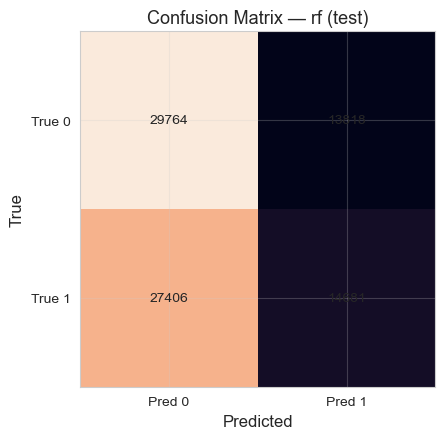

13:37:29 | INFO     | Saved confusion matrix -> artifacts/figures/week7_cls_confusion_matrix_rf.png


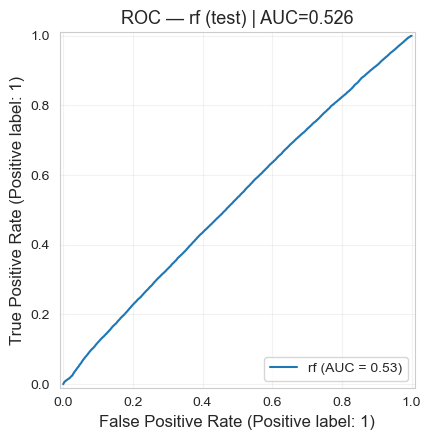

13:37:29 | INFO     | Saved ROC curve -> artifacts/figures/week7_cls_roc_rf.png
13:37:29 | INFO     | [END] Figures (classification) — confusion matrix & ROC in 0.5s


In [47]:
import logging
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, RocCurveDisplay, roc_auc_score

logger = logging.getLogger("week7")

# Reuse predictions path from Cell 14
assert "predictions_out_parquet" in globals(), "Run the previous cell first."

# Resolve figure dir
try:
    fig_dir = Path(FIG_DIR)
except NameError:
    fig_dir = Path("artifacts/figures")
fig_dir.mkdir(parents=True, exist_ok=True)

with step_timer("Figures (classification) — confusion matrix & ROC"):
    preds = pd.read_parquet(predictions_out_parquet)
    # Pick best model by AUC from metrics table
    df_metrics = pd.read_csv(metrics_out_csv).sort_values("roc_auc", ascending=False).reset_index(drop=True)
    best_model = df_metrics.loc[0, "model"]
    logger.info("Best classification model (test): %s (AUC=%.4f)", best_model, df_metrics.loc[0, "roc_auc"])

    P = preds[preds["model"] == best_model].copy()
    y_true = P["y_true"].astype(int).values
    y_pred = P["y_pred"].astype(int).values

    # --- Confusion Matrix ---
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    fig_cm, ax_cm = plt.subplots()
    im = ax_cm.imshow(cm, interpolation="nearest")
    ax_cm.set_title(f"Confusion Matrix — {best_model} (test)")
    ax_cm.set_xticks([0,1]); ax_cm.set_yticks([0,1])
    ax_cm.set_xticklabels(["Pred 0","Pred 1"]); ax_cm.set_yticklabels(["True 0","True 1"])
    for (i, j), v in np.ndenumerate(cm):
        ax_cm.text(j, i, str(v), ha="center", va="center")
    ax_cm.set_xlabel("Predicted"); ax_cm.set_ylabel("True")
    fig_cm.tight_layout()

    cm_path = fig_dir / f"week7_cls_confusion_matrix_{best_model}.png"
    fig_cm.savefig(cm_path, dpi=150)
    plt.show()
    logger.info("Saved confusion matrix -> %s", cm_path)

    # --- ROC Curve (if probabilities available) ---
    if "y_proba" in P.columns and P["y_proba"].notna().any() and len(np.unique(y_true)) > 1:
        y_proba = P["y_proba"].values
        fig_roc, ax_roc = plt.subplots()
        RocCurveDisplay.from_predictions(y_true, y_proba, name=best_model, ax=ax_roc)
        ax_roc.set_title(f"ROC — {best_model} (test) | AUC={roc_auc_score(y_true, y_proba):.3f}")
        fig_roc.tight_layout()

        roc_path = fig_dir / f"week7_cls_roc_{best_model}.png"
        fig_roc.savefig(roc_path, dpi=150)
        plt.show()
        logger.info("Saved ROC curve -> %s", roc_path)
    else:
        logger.info("No probability scores available for ROC (skipping).")


#### Baseline CV (regression)

In [48]:
import json
import logging
from pathlib import Path
from typing import Dict, List, Tuple
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

logger = logging.getLogger("week7")

# Reuse earlier helpers present in your notebook:
# - _load_cv_manifests(cv_folds_csv, tuning_symbols_csv)
# - _df_cv_concat(df_train, df_valid)
# - _subset_by_period(df, start, end)
# - get_feature_columns(df)
# - prepare_regression_matrices(df_train_slice, df_valid_slice, feature_cols)
# - fit_model(model, X, y, name)

def _model_registry_reg(seed: int = 42) -> Dict[str, object]:
    return {
        "ridge": Ridge(random_state=seed),
        "enet":  ElasticNet(random_state=seed, max_iter=5000),
        "rf":    RandomForestRegressor(
                    n_estimators=200, max_depth=None, min_samples_leaf=1,
                    max_features="sqrt", n_jobs=-1, random_state=seed)
    }

def _eval_reg(y_true: np.ndarray, y_pred: np.ndarray) -> Dict[str, float]:
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    return {"mae": mae, "rmse": rmse, "r2": r2}

def run_reg_cv_baselines(
    df_train: pd.DataFrame,
    df_valid: pd.DataFrame,
    cv_folds_csv: Path,
    tuning_symbols_csv: Path,
    out_csv: Path
) -> Path:
    """
    For each CV fold:
      - build X/y matrices (regression) from df subsets
      - fit untuned models (ridge / enet / rf)
      - evaluate on validation
      - append fold-level metrics to out_csv
    """
    with step_timer("Baseline CV (regression)"):
        folds, tuning_symbols = _load_cv_manifests(cv_folds_csv, tuning_symbols_csv)
        df_cv = _df_cv_concat(df_train, df_valid)
        feature_cols = get_feature_columns(df_cv)

        rows: List[Dict] = []
        models = _model_registry_reg()
        for _, row in folds.iterrows():
            fold_id = int(row["fold"])
            tr = _subset_by_period(df_cv, row["train_start"], row["train_end"], tuning_symbols)
            va = _subset_by_period(df_cv, row["val_start"], row["val_end"], tuning_symbols)

            # Build matrices with your existing helper
            X_tr, y_tr, X_va, y_va = prepare_regression_matrices(tr, va, feature_cols)

            for name, est in models.items():
                mdl = fit_model(est, X_tr, y_tr, name=f"{name}-fold{fold_id}")
                y_hat = mdl.predict(X_va)
                m = _eval_reg(y_va, y_hat)
                rows.append({
                    "fold": fold_id,
                    "model": name,
                    "params": json.dumps({k: v for k, v in est.get_params().items()
                                          if k in ("alpha","l1_ratio","n_estimators","max_depth",
                                                   "min_samples_leaf","max_features")}),
                    **m
                })

        df_out = pd.DataFrame(rows).sort_values(["model","fold"]).reset_index(drop=True)
        out_csv.parent.mkdir(parents=True, exist_ok=True)
        df_out.to_csv(out_csv, index=False)
        logger.info("Saved baseline CV metrics (regression) -> %s", out_csv)
        return out_csv


#### Baseline CV (regression) — execute

In [49]:
from pathlib import Path
import pandas as pd

ts_tag = pd.Timestamp.utcnow().strftime("%Y%m%d_%H%M%S")
cv_folds_csv = Path("artifacts/cv/week7_cls_cv_folds.csv")  # reuse same folds file
tuning_symbols_csv = Path("artifacts/cv/week7_cls_tuning_symbols.csv")

reg_baseline_csv = Path(MET_DIR) / f"week7_reg_cv_baselines_{ts_tag}.csv"

_ = run_reg_cv_baselines(
    df_train=df_train,
    df_valid=df_valid,
    cv_folds_csv=cv_folds_csv,
    tuning_symbols_csv=tuning_symbols_csv,
    out_csv=reg_baseline_csv
)

13:45:25 | INFO     | [START] Baseline CV (regression)
13:45:27 | INFO     | [START] Prepare matrices (regression)
13:45:27 | INFO     | X_train (REG) dtype mix: {'float64': 15, 'bool': 5, 'int64': 2}
13:45:27 | INFO     | X_valid (REG) dtype mix: {'float64': 15, 'bool': 5, 'int64': 2}
13:45:27 | INFO     | REG matrices ready — X_train:(57402, 22)  X_valid:(32714, 22)
13:45:27 | INFO     | [END] Prepare matrices (regression) in 0.1s
13:45:27 | INFO     | [START] Fit ridge-fold1
13:45:27 | INFO     | [END] Fit ridge-fold1 in 0.0s
13:45:27 | INFO     | [START] Fit enet-fold1
13:45:27 | INFO     | [END] Fit enet-fold1 in 0.2s
13:45:27 | INFO     | [START] Fit rf-fold1
13:45:43 | INFO     | [END] Fit rf-fold1 in 16.2s
13:45:44 | INFO     | [START] Prepare matrices (regression)
13:45:44 | INFO     | X_train (REG) dtype mix: {'float64': 15, 'bool': 5, 'int64': 2}
13:45:44 | INFO     | X_valid (REG) dtype mix: {'float64': 15, 'bool': 5, 'int64': 2}
13:45:44 | INFO     | REG matrices ready — X

#### Ridge (regression) — grid CV

In [50]:
import json
import logging
from pathlib import Path
from typing import Dict, List
import pandas as pd
from sklearn.linear_model import Ridge

logger = logging.getLogger("week7")

def run_reg_grid_ridge(
    df_train: pd.DataFrame,
    df_valid: pd.DataFrame,
    cv_folds_csv: Path,
    tuning_symbols_csv: Path,
    out_csv: Path,
    alpha_grid: List[float] = (1e-3, 1e-2, 1e-1, 1, 10),
    seed: int = 42
) -> Path:
    with step_timer("Grid CV (regression) — Ridge"):
        folds, tuning_symbols = _load_cv_manifests(cv_folds_csv, tuning_symbols_csv)
        df_cv = _df_cv_concat(df_train, df_valid)
        feature_cols = get_feature_columns(df_cv)

        rows = []
        for _, row in folds.iterrows():
            fold_id = int(row["fold"])
            tr = _subset_by_period(df_cv, row["train_start"], row["train_end"], tuning_symbols)
            va = _subset_by_period(df_cv, row["val_start"], row["val_end"], tuning_symbols)
            X_tr, y_tr, X_va, y_va = prepare_regression_matrices(tr, va, feature_cols)

            for a in alpha_grid:
                est = Ridge(alpha=float(a), random_state=seed)
                mdl = fit_model(est, X_tr, y_tr, name=f"ridge-a{a}-fold{fold_id}")
                y_hat = mdl.predict(X_va)
                m = _eval_reg(y_va, y_hat)
                rows.append({
                    "fold": fold_id,
                    "model": "ridge",
                    "params": json.dumps({"alpha": float(a)}),
                    **m
                })

        df_out = pd.DataFrame(rows).sort_values(["fold","model"]).reset_index(drop=True)
        out_csv.parent.mkdir(parents=True, exist_ok=True)
        df_out.to_csv(out_csv, index=False)
        logger.info("Saved grid CV (ridge) -> %s", out_csv)
        return out_csv

def _select_best_params_ridge(cv_csv: Path) -> Dict:
    df = pd.read_csv(cv_csv)
    agg = (df.assign(alpha=df["params"].apply(lambda s: json.loads(s)["alpha"]))
             .groupby("alpha", as_index=False)
             .agg(mae=("mae","mean"), rmse=("rmse","mean"), r2=("r2","mean"))
             .sort_values(["mae","rmse","r2"], ascending=[True, True, False]))
    best = {"alpha": float(agg.iloc[0]["alpha"])}
    logger.info("Best Ridge params (CV mean): %s", best)
    return best

def _update_best_params_json_reg(best_params_path: Path, model_key: str, params: Dict):
    best_params_path.parent.mkdir(parents=True, exist_ok=True)
    try:
        data = json.loads(best_params_path.read_text()) if best_params_path.exists() else {}
    except Exception:
        data = {}
    data[model_key] = params
    best_params_path.write_text(json.dumps(data, indent=2))
    logger.info("Updated reg best params JSON -> %s", best_params_path)

#### Ridge (regression) — execute grid CV & pick best

In [51]:
from pathlib import Path
import pandas as pd

ts_tag = pd.Timestamp.utcnow().strftime("%Y%m%d_%H%M%S")
cv_folds_csv = Path("artifacts/cv/week7_cls_cv_folds.csv")
tuning_symbols_csv = Path("artifacts/cv/week7_cls_tuning_symbols.csv")

ridge_cv_csv = Path(MET_DIR) / f"week7_reg_cv_grid_ridge_{ts_tag}.csv"
reg_best_params_json = Path(MET_DIR) / "week7_reg_best_params.json"

_ = run_reg_grid_ridge(
    df_train=df_train,
    df_valid=df_valid,
    cv_folds_csv=cv_folds_csv,
    tuning_symbols_csv=tuning_symbols_csv,
    out_csv=ridge_cv_csv,
    alpha_grid=[1e-3, 1e-2, 1e-1, 1.0, 10.0]
)

best_ridge = _select_best_params_ridge(ridge_cv_csv)
_update_best_params_json_reg(reg_best_params_json, model_key="ridge", params=best_ridge)

13:56:28 | INFO     | [START] Grid CV (regression) — Ridge
13:56:29 | INFO     | [START] Prepare matrices (regression)
13:56:29 | INFO     | X_train (REG) dtype mix: {'float64': 15, 'bool': 5, 'int64': 2}
13:56:30 | INFO     | X_valid (REG) dtype mix: {'float64': 15, 'bool': 5, 'int64': 2}
13:56:30 | INFO     | REG matrices ready — X_train:(57402, 22)  X_valid:(32714, 22)
13:56:30 | INFO     | [END] Prepare matrices (regression) in 0.1s
13:56:30 | INFO     | [START] Fit ridge-a0.001-fold1
13:56:30 | INFO     | [END] Fit ridge-a0.001-fold1 in 0.0s
13:56:30 | INFO     | [START] Fit ridge-a0.01-fold1
13:56:30 | INFO     | [END] Fit ridge-a0.01-fold1 in 0.0s
13:56:30 | INFO     | [START] Fit ridge-a0.1-fold1
13:56:30 | INFO     | [END] Fit ridge-a0.1-fold1 in 0.0s
13:56:30 | INFO     | [START] Fit ridge-a1.0-fold1
13:56:30 | INFO     | [END] Fit ridge-a1.0-fold1 in 0.0s
13:56:30 | INFO     | [START] Fit ridge-a10.0-fold1
13:56:30 | INFO     | [END] Fit ridge-a10.0-fold1 in 0.0s
13:56:30 | 

#### Random Forest (regression) — grid CV

In [52]:
import json
import logging
from pathlib import Path
from typing import Dict, List
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

logger = logging.getLogger("week7")

def run_reg_grid_rf(
    df_train: pd.DataFrame,
    df_valid: pd.DataFrame,
    cv_folds_csv: Path,
    tuning_symbols_csv: Path,
    out_csv: Path,
    n_estimators_grid: List[int] = (200, 400),
    max_depth_grid: List[int | None] = (None, 8, 12, 16),
    min_samples_leaf_grid: List[int] = (1, 5),
    seed: int = 42
) -> Path:
    with step_timer("Grid CV (regression) — RandomForestRegressor"):
        folds, tuning_symbols = _load_cv_manifests(cv_folds_csv, tuning_symbols_csv)
        df_cv = _df_cv_concat(df_train, df_valid)
        feature_cols = get_feature_columns(df_cv)

        rows = []
        for _, row in folds.iterrows():
            fold_id = int(row["fold"])
            tr = _subset_by_period(df_cv, row["train_start"], row["train_end"], tuning_symbols)
            va = _subset_by_period(df_cv, row["val_start"], row["val_end"], tuning_symbols)
            X_tr, y_tr, X_va, y_va = prepare_regression_matrices(tr, va, feature_cols)

            for n in n_estimators_grid:
                for d in max_depth_grid:
                    for leaf in min_samples_leaf_grid:
                        est = RandomForestRegressor(
                            n_estimators=int(n),
                            max_depth=None if d is None else int(d),
                            min_samples_leaf=int(leaf),
                            max_features="sqrt",
                            n_jobs=-1,
                            random_state=seed
                        )
                        mdl = fit_model(est, X_tr, y_tr, name=f"rf-{n}-{d}-{leaf}-fold{fold_id}")
                        y_hat = mdl.predict(X_va)
                        m = _eval_reg(y_va, y_hat)
                        rows.append({
                            "fold": fold_id,
                            "model": "rf",
                            "params": json.dumps({
                                "n_estimators": int(n),
                                "max_depth": (None if d is None else int(d)),
                                "min_samples_leaf": int(leaf),
                                "max_features": "sqrt"
                            }),
                            **m
                        })

        df_out = pd.DataFrame(rows).sort_values(["fold","model"]).reset_index(drop=True)
        out_csv.parent.mkdir(parents=True, exist_ok=True)
        df_out.to_csv(out_csv, index=False)
        logger.info("Saved grid CV (rf reg) -> %s", out_csv)
        return out_csv

def _select_best_params_rf_reg(cv_csv: Path) -> Dict:
    df = pd.read_csv(cv_csv)
    P = df["params"].apply(json.loads)
    df = pd.concat([df.drop(columns=["params"]).reset_index(drop=True),
                    pd.json_normalize(P).reset_index(drop=True)], axis=1)
    agg = (df.groupby(["n_estimators","max_depth","min_samples_leaf","max_features"], as_index=False)
             .agg(mae=("mae","mean"), rmse=("rmse","mean"), r2=("r2","mean"))
             .sort_values(["mae","rmse","r2"], ascending=[True, True, False]))
    best_row = agg.iloc[0].to_dict()
    best = {
        "n_estimators": int(best_row["n_estimators"]),
        "max_depth": None if pd.isna(best_row["max_depth"]) else int(best_row["max_depth"]),
        "min_samples_leaf": int(best_row["min_samples_leaf"]),
        "max_features": str(best_row["max_features"])
    }
    logger.info("Best RF reg params (CV mean): %s", best)
    return best


#### Random Forest (regression) — execute grid CV & pick best

In [53]:
from pathlib import Path
import pandas as pd

ts_tag = pd.Timestamp.utcnow().strftime("%Y%m%d_%H%M%S")
cv_folds_csv = Path("artifacts/cv/week7_cls_cv_folds.csv")
tuning_symbols_csv = Path("artifacts/cv/week7_cls_tuning_symbols.csv")

rf_reg_cv_csv = Path(MET_DIR) / f"week7_reg_cv_grid_rf_{ts_tag}.csv"
reg_best_params_json = Path(MET_DIR) / "week7_reg_best_params.json"

_ = run_reg_grid_rf(
    df_train=df_train,
    df_valid=df_valid,
    cv_folds_csv=cv_folds_csv,
    tuning_symbols_csv=tuning_symbols_csv,
    out_csv=rf_reg_cv_csv,
    n_estimators_grid=[200, 400],
    max_depth_grid=[None, 8, 12, 16],
    min_samples_leaf_grid=[1, 5]
)

best_rf_reg = _select_best_params_rf_reg(rf_reg_cv_csv)
_update_best_params_json_reg(reg_best_params_json, model_key="rf", params=best_rf_reg)


13:56:42 | INFO     | [START] Grid CV (regression) — RandomForestRegressor
13:56:43 | INFO     | [START] Prepare matrices (regression)
13:56:43 | INFO     | X_train (REG) dtype mix: {'float64': 15, 'bool': 5, 'int64': 2}
13:56:43 | INFO     | X_valid (REG) dtype mix: {'float64': 15, 'bool': 5, 'int64': 2}
13:56:43 | INFO     | REG matrices ready — X_train:(57402, 22)  X_valid:(32714, 22)
13:56:43 | INFO     | [END] Prepare matrices (regression) in 0.0s
13:56:43 | INFO     | [START] Fit rf-200-None-1-fold1
13:56:54 | INFO     | [END] Fit rf-200-None-1-fold1 in 10.5s
13:56:54 | INFO     | [START] Fit rf-200-None-5-fold1
13:57:03 | INFO     | [END] Fit rf-200-None-5-fold1 in 9.1s
13:57:03 | INFO     | [START] Fit rf-200-8-1-fold1
13:57:06 | INFO     | [END] Fit rf-200-8-1-fold1 in 3.2s
13:57:06 | INFO     | [START] Fit rf-200-8-5-fold1
13:57:09 | INFO     | [END] Fit rf-200-8-5-fold1 in 2.8s
13:57:10 | INFO     | [START] Fit rf-200-12-1-fold1
13:57:15 | INFO     | [END] Fit rf-200-12-1-fo

#### Final Evaluation (regression) — helpers

In [56]:
#### Final Evaluation (regression) — helpers (aligned)
import json
import logging
from pathlib import Path
from typing import Dict, Tuple, List
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

logger = logging.getLogger("week7")

def _final_train_test_windows_reg(cv_folds_csv: Path) -> Tuple[pd.Timestamp, pd.Timestamp, pd.Timestamp, pd.Timestamp]:
    folds = pd.read_csv(cv_folds_csv)
    for c in ("train_start","train_end","val_start","val_end"):
        folds[c] = pd.to_datetime(folds[c], utc=True).dt.tz_localize(None)
    last = folds.sort_values("fold").iloc[-1]
    train_start, train_end = folds["train_start"].min(), last["val_start"] - pd.Timedelta(seconds=1)
    test_start, test_end = last["val_start"], last["val_end"]
    return train_start, train_end, test_start, test_end

def _subset_by_period_all(df: pd.DataFrame, start, end) -> pd.DataFrame:
    m = (df["timestamp"] >= start) & (df["timestamp"] <= end)
    return df.loc[m].copy()

def _build_best_estimators_reg(best_params_json: Path, seed: int = 42) -> Dict[str, object]:
    params = {}
    if best_params_json.exists():
        try:
            params = json.loads(best_params_json.read_text())
        except Exception:
            params = {}
    ests: Dict[str, object] = {}
    if "ridge" in params:
        a = float(params["ridge"].get("alpha", 1.0))
        ests["ridge"] = Ridge(alpha=a, random_state=seed)
    if "enet" in params:
        ep = params["enet"]
        ests["enet"] = ElasticNet(alpha=float(ep.get("alpha", 0.1)),
                                  l1_ratio=float(ep.get("l1_ratio", 0.5)),
                                  max_iter=5000, random_state=seed)
    if "rf" in params:
        rp = params["rf"]
        ests["rf"] = RandomForestRegressor(
            n_estimators=int(rp.get("n_estimators", 200)),
            max_depth=None if rp.get("max_depth") in (None, "None", np.nan) else int(rp.get("max_depth")),
            min_samples_leaf=int(rp.get("min_samples_leaf", 1)),
            max_features=str(rp.get("max_features", "sqrt")),
            n_jobs=-1,
            random_state=seed
        )
    return ests

def _eval_reg(y_true: np.ndarray, y_pred: np.ndarray) -> Dict[str, float]:
    return {
        "mae": mean_absolute_error(y_true, y_pred),
        "rmse": mean_squared_error(y_true, y_pred, squared=False),
        "r2": r2_score(y_true, y_pred),
    }

def _align_df_to_X(df_te: pd.DataFrame, X_te, feature_cols: List[str]) -> pd.DataFrame:
    # Preferred: if X_te is a DataFrame, use its index directly.
    if hasattr(X_te, "index"):
        try:
            return df_te.loc[X_te.index, ["symbol", "timestamp"]].copy()
        except Exception:
            pass
    # Fallback: derive mask from non-NaN feature rows (mirrors typical matrix prep).
    mask = df_te[feature_cols].notna().all(axis=1)
    return df_te.loc[mask, ["symbol", "timestamp"]].copy()

def evaluate_reg_final(
    df_train: pd.DataFrame,
    df_valid: pd.DataFrame,
    cv_folds_csv: Path,
    best_params_json: Path,
    metrics_out_csv: Path,
    per_symbol_out_csv: Path,
    predictions_out_parquet: Path,
    model_keys: List[str] = ("ridge","rf","enet")
) -> Tuple[Path, Path, Path]:
    with step_timer("Final Evaluation (regression)"):
        tr_start, tr_end, te_start, te_end = _final_train_test_windows_reg(cv_folds_csv)
        logger.info("Final windows | train: %s → %s | test: %s → %s", tr_start, tr_end, te_start, te_end)

        df_all = _df_cv_concat(df_train, df_valid)
        feature_cols = get_feature_columns(df_all)

        df_tr = _subset_by_period_all(df_all, tr_start, tr_end)
        df_te = _subset_by_period_all(df_all, te_start, te_end)

        X_tr, y_tr, X_te, y_te = prepare_regression_matrices(df_tr, df_te, feature_cols)

        ests = _build_best_estimators_reg(best_params_json)
        rows = []
        preds_all = []

        for key in model_keys:
            if key not in ests:
                logger.info("Skipping model '%s' (no best params found).", key)
                continue

            est = ests[key]
            mdl = fit_model(est, X_tr, y_tr, name=f"{key}-final")
            y_hat = mdl.predict(X_te)

            # Align output rows to the exact rows used in X_te/y_te
            df_out = _align_df_to_X(df_te, X_te, feature_cols)
            # If needed, trim to match lengths exactly
            n = min(len(df_out), len(y_te), len(y_hat))
            df_out = df_out.iloc[:n].copy()
            y_true_use = y_te[:n]
            y_pred_use = y_hat[:n]

            m = _eval_reg(y_true_use, y_pred_use)
            df_out["y_true"] = y_true_use
            df_out["y_pred"] = y_pred_use
            df_out["model"] = key
            preds_all.append(df_out)

            rows.append({"model": key, **m, "n_obs_test": int(n)})

        # Save overall metrics
        df_metrics = pd.DataFrame(rows).sort_values("mae").reset_index(drop=True)
        metrics_out_csv.parent.mkdir(parents=True, exist_ok=True)
        df_metrics.to_csv(metrics_out_csv, index=False)

        # Save predictions
        df_preds = pd.concat(preds_all, ignore_index=True) if preds_all else pd.DataFrame()
        predictions_out_parquet.parent.mkdir(parents=True, exist_ok=True)
        if len(df_preds):
            df_preds.to_parquet(predictions_out_parquet, index=False)

        # Per-symbol metrics
        per_symbol_out_csv.parent.mkdir(parents=True, exist_ok=True)
        if len(df_preds):
            rows = []
            for (key, gk) in df_preds.groupby("model"):
                for sym, g in gk.groupby("symbol"):
                    rows.append({
                        "symbol": sym,
                        "model": key,
                        **_eval_reg(g["y_true"].values, g["y_pred"].values),
                        "n_obs": int(len(g))
                    })
            pd.DataFrame(rows).to_csv(per_symbol_out_csv, index=False)
        else:
            pd.DataFrame(columns=["symbol","model","mae","rmse","r2","n_obs"]).to_csv(per_symbol_out_csv, index=False)

        logger.info("Saved final regression metrics -> %s", metrics_out_csv)
        logger.info("Saved per-symbol metrics -> %s", per_symbol_out_csv)
        logger.info("Saved test predictions -> %s", predictions_out_parquet)
        return metrics_out_csv, per_symbol_out_csv, predictions_out_parquet


#### Final Evaluation (regression) — execute (train all, test last fold)

In [57]:
from pathlib import Path
import pandas as pd

ts_tag = pd.Timestamp.utcnow().strftime("%Y%m%d_%H%M%S")
cv_folds_csv = Path("artifacts/cv/week7_cls_cv_folds.csv")
reg_best_params_json = Path(MET_DIR) / "week7_reg_best_params.json"

reg_metrics_out_csv = Path(MET_DIR) / f"week7_reg_final_metrics_{ts_tag}.csv"
reg_per_symbol_out_csv = Path(MET_DIR) / f"week7_reg_per_symbol_metrics_{ts_tag}.csv"
reg_predictions_out_parquet = Path("artifacts/predictions") / f"week7_reg_predictions_{ts_tag}.parquet"

_ = evaluate_reg_final(
    df_train=df_train,
    df_valid=df_valid,
    cv_folds_csv=cv_folds_csv,
    best_params_json=reg_best_params_json,
    metrics_out_csv=reg_metrics_out_csv,
    per_symbol_out_csv=reg_per_symbol_out_csv,
    predictions_out_parquet=reg_predictions_out_parquet,
    model_keys=["ridge","rf","enet"]
)

17:39:16 | INFO     | [START] Final Evaluation (regression)
17:39:16 | INFO     | Final windows | train: 2024-01-02 00:00:00 → 2024-03-25 23:59:59 | test: 2024-03-26 00:00:00 → 2024-04-01 23:59:59
17:39:18 | INFO     | [START] Prepare matrices (regression)
17:39:19 | INFO     | X_train (REG) dtype mix: {'float64': 15, 'bool': 5, 'int64': 2}
17:39:19 | INFO     | X_valid (REG) dtype mix: {'float64': 15, 'bool': 5, 'int64': 2}
17:39:19 | INFO     | REG matrices ready — X_train:(1802449, 22)  X_valid:(85208, 22)
17:39:19 | INFO     | [END] Prepare matrices (regression) in 1.3s
17:39:19 | INFO     | [START] Fit ridge-final
17:39:19 | INFO     | [END] Fit ridge-final in 0.3s
17:39:19 | INFO     | [START] Fit rf-final
17:43:20 | INFO     | [END] Fit rf-final in 240.8s
17:43:20 | INFO     | Skipping model 'enet' (no best params found).
17:43:21 | INFO     | Saved final regression metrics -> artifacts/metrics/week7_reg_final_metrics_20251015_213916.csv
17:43:21 | INFO     | Saved per-symbol me

#### Final Evaluation (regression) — console summary

In [58]:
import logging
import pandas as pd

logger = logging.getLogger("week7")
assert "reg_metrics_out_csv" in globals(), "Run the previous cell first."

with step_timer("Summary (regression) — console + table"):
    dfm = pd.read_csv(reg_metrics_out_csv)
    for _, r in dfm.iterrows():
        logger.info(
            "TEST | model=%s | MAE=%.6f | RMSE=%.6f | R2=%.4f | n=%d",
            r["model"], r["mae"], r["rmse"], r["r2"], r["n_obs_test"]
        )
    display(dfm.sort_values("mae").reset_index(drop=True))


17:45:10 | INFO     | [START] Summary (regression) — console + table
17:45:10 | INFO     | TEST | model=rf | MAE=0.001025 | RMSE=0.004690 | R2=0.0228 | n=85208
17:45:10 | INFO     | TEST | model=ridge | MAE=0.001029 | RMSE=0.004745 | R2=0.0001 | n=85208


,model,mae,rmse,r2,n_obs_test
0,rf,0.001025,0.004690,0.022813,85208
1,ridge,0.001029,0.004745,0.000078,85208


17:45:10 | INFO     | [END] Summary (regression) — console + table in 0.0s


#### Final Evaluation (regression) — visualizations (residuals & error histogram)

17:45:18 | INFO     | [START] Figures (regression) — residuals & error histogram
17:45:18 | INFO     | Best regression model (test): rf | MAE=0.001025


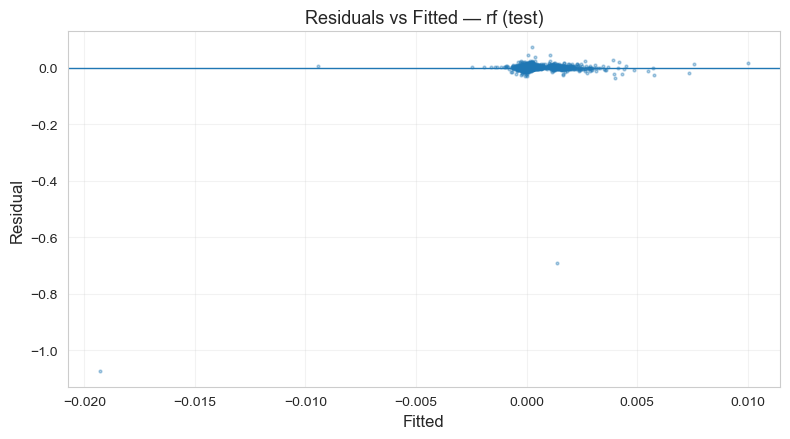

17:45:18 | INFO     | Saved residuals plot -> artifacts/figures/week7_reg_residuals_rf.png


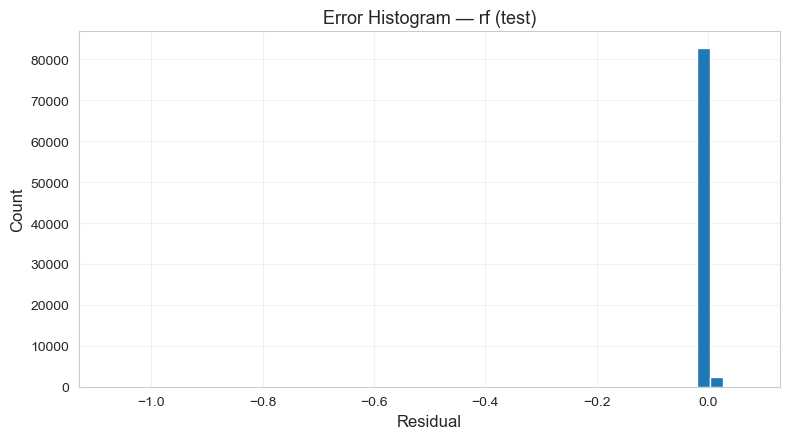

17:45:18 | INFO     | Saved error histogram -> artifacts/figures/week7_reg_error_hist_rf.png
17:45:18 | INFO     | [END] Figures (regression) — residuals & error histogram in 0.6s


In [59]:
import logging
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

logger = logging.getLogger("week7")

assert "reg_predictions_out_parquet" in globals() and "reg_metrics_out_csv" in globals(), "Run the previous cell first."

try:
    fig_dir = Path(FIG_DIR)
except NameError:
    fig_dir = Path("artifacts/figures")
fig_dir.mkdir(parents=True, exist_ok=True)

with step_timer("Figures (regression) — residuals & error histogram"):
    preds = pd.read_parquet(reg_predictions_out_parquet)
    dfm = pd.read_csv(reg_metrics_out_csv).sort_values("mae").reset_index(drop=True)
    best_model = dfm.loc[0, "model"]
    logger.info("Best regression model (test): %s | MAE=%.6f", best_model, dfm.loc[0, "mae"])

    P = preds[preds["model"] == best_model].copy()
    y_true = P["y_true"].values
    y_pred = P["y_pred"].values
    resid = y_true - y_pred

    # Residuals vs fitted
    fig1, ax1 = plt.subplots()
    ax1.scatter(y_pred, resid, s=4, alpha=0.35)
    ax1.axhline(0, lw=1)
    ax1.set_title(f"Residuals vs Fitted — {best_model} (test)")
    ax1.set_xlabel("Fitted")
    ax1.set_ylabel("Residual")
    fig1.tight_layout()
    f1_path = fig_dir / f"week7_reg_residuals_{best_model}.png"
    fig1.savefig(f1_path, dpi=150)
    plt.show()
    logger.info("Saved residuals plot -> %s", f1_path)

    # Error histogram
    fig2, ax2 = plt.subplots()
    ax2.hist(resid, bins=50)
    ax2.set_title(f"Error Histogram — {best_model} (test)")
    ax2.set_xlabel("Residual")
    ax2.set_ylabel("Count")
    fig2.tight_layout()
    f2_path = fig_dir / f"week7_reg_error_hist_{best_model}.png"
    fig2.savefig(f2_path, dpi=150)
    plt.show()
    logger.info("Saved error histogram -> %s", f2_path)


In [60]:
import json, logging
from pathlib import Path
import pandas as pd

logger = logging.getLogger("week7")

def _latest(glob_pat: str) -> str | None:
    p = sorted(Path(".").glob(glob_pat), key=lambda x: x.stat().st_mtime, reverse=True)
    return str(p[0]) if p else None

with step_timer("Build week7 manifest"):
    manifest = {
        "cv": {
            "folds": _latest("artifacts/cv/week7_cls_cv_folds*.csv"),
            "tuning_symbols": _latest("artifacts/cv/week7_cls_tuning_symbols*.csv")
        },
        "classification": {
            "cv_baselines": _latest(f"{MET_DIR}/week7_cls_cv_baselines_*.csv"),
            "cv_logreg": _latest(f"{MET_DIR}/week7_cls_cv_grid_logreg_*.csv"),
            "cv_rf": _latest(f"{MET_DIR}/week7_cls_cv_grid_rf_*.csv"),
            "cv_tree": _latest(f"{MET_DIR}/week7_cls_cv_grid_tree_*.csv"),
            "best_params_json": _latest(f"{MET_DIR}/week7_cls_best_params.json"),
            "final_metrics": _latest(f"{MET_DIR}/week7_cls_final_metrics_*.csv"),
            "per_symbol_metrics": _latest(f"{MET_DIR}/week7_cls_per_symbol_metrics_*.csv"),
            "predictions": _latest("artifacts/predictions/week7_cls_predictions_*.parquet"),
            "fig_confusion": _latest(f"{FIG_DIR}/week7_cls_confusion_matrix_*.png"),
            "fig_roc": _latest(f"{FIG_DIR}/week7_cls_roc_*.png"),
        },
        "regression": {
            "cv_baselines": _latest(f"{MET_DIR}/week7_reg_cv_baselines_*.csv"),
            "cv_ridge": _latest(f"{MET_DIR}/week7_reg_cv_grid_ridge_*.csv"),
            "cv_rf": _latest(f"{MET_DIR}/week7_reg_cv_grid_rf_*.csv"),
            "best_params_json": _latest(f"{MET_DIR}/week7_reg_best_params.json"),
            "final_metrics": _latest(f"{MET_DIR}/week7_reg_final_metrics_*.csv"),
            "per_symbol_metrics": _latest(f"{MET_DIR}/week7_reg_per_symbol_metrics_*.csv"),
            "predictions": _latest("artifacts/predictions/week7_reg_predictions_*.parquet"),
            "fig_residuals": _latest(f"{FIG_DIR}/week7_reg_residuals_*.png"),
            "fig_error_hist": _latest(f"{FIG_DIR}/week7_reg_error_hist_*.png"),
        }
    }
    ts_tag = pd.Timestamp.utcnow().strftime("%Y%m%d_%H%M%S")
    manifest_path = Path(MET_DIR) / f"week7_manifest_{ts_tag}.json"
    manifest_path.write_text(json.dumps(manifest, indent=2))
    logger.info("Manifest written -> %s", manifest_path)


18:13:11 | INFO     | [START] Build week7 manifest
18:13:11 | INFO     | Manifest written -> artifacts/metrics/week7_manifest_20251015_221311.json
18:13:11 | INFO     | [END] Build week7 manifest in 0.0s


In [61]:
import json, logging
from pathlib import Path
import pandas as pd
import numpy as np

logger = logging.getLogger("week7")

def _latest(path_glob: str) -> Path | None:
    p = sorted(Path(".").glob(path_glob), key=lambda x: x.stat().st_mtime, reverse=True)
    return p[0] if p else None

with step_timer("Build report tables"):
    # --- Table 1: Data summary ---
    df_all = pd.concat([_df_cv_concat(df_train, df_valid)], ignore_index=True)
    n_rows = len(df_all)
    n_syms = df_all["symbol"].nunique()
    t0, t1 = df_all["timestamp"].min(), df_all["timestamp"].max()
    tbl1 = pd.DataFrame([{
        "rows_total": int(n_rows),
        "symbols": int(n_syms),
        "start": pd.to_datetime(t0),
        "end": pd.to_datetime(t1)
    }])
    tbl1_path = Path(MET_DIR) / "week7_table_data_summary.csv"
    tbl1.to_csv(tbl1_path, index=False)
    logger.info("Table 1 -> %s", tbl1_path)

    # --- Table 3: Classification CV summary (mean±sd per model) ---
    def _cv_agg_cls(csv_path: Path, model_name: str) -> pd.DataFrame:
        df = pd.read_csv(csv_path)
        g = df.groupby("model").agg(
            roc_auc_mean=("roc_auc","mean"), roc_auc_sd=("roc_auc","std"),
            f1_mean=("f1","mean"), f1_sd=("f1","std"),
            accuracy_mean=("accuracy","mean"), accuracy_sd=("accuracy","std"),
            folds=("fold","nunique")
        ).reset_index()
        if "model" not in g.columns or g.empty:
            g = pd.DataFrame([{"model": model_name}]).assign(
                roc_auc_mean=np.nan, roc_auc_sd=np.nan,
                f1_mean=np.nan, f1_sd=np.nan,
                accuracy_mean=np.nan, accuracy_sd=np.nan,
                folds=np.nan
            )
        return g

    cls_cv_files = [
        (_latest(f"{MET_DIR}/week7_cls_cv_grid_logreg_*.csv"), "logreg"),
        (_latest(f"{MET_DIR}/week7_cls_cv_grid_rf_*.csv"), "rf"),
        (_latest(f"{MET_DIR}/week7_cls_cv_grid_tree_*.csv"), "tree"),
    ]
    parts = []
    for pth, name in cls_cv_files:
        if pth is not None:
            parts.append(_cv_agg_cls(pth, name))
    tbl3 = pd.concat(parts, ignore_index=True) if parts else pd.DataFrame()
    tbl3_path = Path(MET_DIR) / "week7_table_cls_cv_summary.csv"
    tbl3.to_csv(tbl3_path, index=False)
    logger.info("Table 3 -> %s", tbl3_path)

    # --- Table 4: Regression CV summary (mean±sd per model) ---
    def _cv_agg_reg(csv_path: Path, model_name: str) -> pd.DataFrame:
        df = pd.read_csv(csv_path)
        g = df.groupby("model").agg(
            mae_mean=("mae","mean"), mae_sd=("mae","std"),
            rmse_mean=("rmse","mean"), rmse_sd=("rmse","std"),
            r2_mean=("r2","mean"), r2_sd=("r2","std"),
            folds=("fold","nunique")
        ).reset_index()
        if "model" not in g.columns or g.empty:
            g = pd.DataFrame([{"model": model_name}]).assign(
                mae_mean=np.nan, mae_sd=np.nan,
                rmse_mean=np.nan, rmse_sd=np.nan,
                r2_mean=np.nan, r2_sd=np.nan,
                folds=np.nan
            )
        return g

    reg_cv_files = [
        (_latest(f"{MET_DIR}/week7_reg_cv_grid_ridge_*.csv"), "ridge"),
        (_latest(f"{MET_DIR}/week7_reg_cv_grid_rf_*.csv"), "rf"),
    ]
    parts = []
    for pth, name in reg_cv_files:
        if pth is not None:
            parts.append(_cv_agg_reg(pth, name))
    tbl4 = pd.concat(parts, ignore_index=True) if parts else pd.DataFrame()
    tbl4_path = Path(MET_DIR) / "week7_table_reg_cv_summary.csv"
    tbl4.to_csv(tbl4_path, index=False)
    logger.info("Table 4 -> %s", tbl4_path)

    # --- Table 5: Final test comparison (classification + regression) ---
    cls_final = _latest(f"{MET_DIR}/week7_cls_final_metrics_*.csv")
    reg_final = _latest(f"{MET_DIR}/week7_reg_final_metrics_*.csv")
    frames = []
    if cls_final is not None:
        d = pd.read_csv(cls_final).assign(task="classification")
        frames.append(d[["task","model","roc_auc","f1","accuracy","n_obs_test"]])
    if reg_final is not None:
        d = pd.read_csv(reg_final).assign(task="regression")
        frames.append(d[["task","model","mae","rmse","r2","n_obs_test"]])
    tbl5 = pd.concat(frames, ignore_index=True) if frames else pd.DataFrame()
    tbl5_path = Path(MET_DIR) / "week7_table_final_test_comparison.csv"
    tbl5.to_csv(tbl5_path, index=False)
    logger.info("Table 5 -> %s", tbl5_path)


18:13:27 | INFO     | [START] Build report tables
18:13:29 | INFO     | Table 1 -> artifacts/metrics/week7_table_data_summary.csv
18:13:29 | INFO     | Table 3 -> artifacts/metrics/week7_table_cls_cv_summary.csv
18:13:29 | INFO     | Table 4 -> artifacts/metrics/week7_table_reg_cv_summary.csv
18:13:29 | INFO     | Table 5 -> artifacts/metrics/week7_table_final_test_comparison.csv
18:13:29 | INFO     | [END] Build report tables in 1.3s


In [62]:
import logging, warnings, json
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, RocCurveDisplay, roc_auc_score

logger = logging.getLogger("week7")
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

def render_full_report(MET_DIR=MET_DIR, FIG_DIR=FIG_DIR):
    """
    Render all important results to the notebook/console:
      - Data summary
      - Classification final metrics (+ confusion matrix & ROC for best model)
      - Regression final metrics (+ residuals vs fitted & error histogram for best model)
      - Per-symbol distributions (accuracy/MAE)
      - CV summaries (classification & regression)
      - Best hyperparameters (JSON)
    Reads the *latest* artifacts produced earlier in Week 7.
    """
    met = Path(MET_DIR); figdir = Path(FIG_DIR)
    figdir.mkdir(parents=True, exist_ok=True)

    def _latest(glob_pat: str):
        ps = sorted(Path(".").glob(glob_pat), key=lambda p: p.stat().st_mtime, reverse=True)
        return ps[0] if ps else None

    def _display_df(df: pd.DataFrame, title: str):
        logger.info("TABLE: %s | rows=%d cols=%d", title, len(df), df.shape[1])
        display(df)

    # 1) Data summary
    if "df_train" in globals() and "df_valid" in globals():
        df_all = pd.concat([_df_cv_concat(df_train, df_valid)], ignore_index=True)
        tbl = pd.DataFrame([{
            "rows_total": int(len(df_all)),
            "symbols": int(df_all["symbol"].nunique()),
            "start": pd.to_datetime(df_all["timestamp"].min()),
            "end": pd.to_datetime(df_all["timestamp"].max())
        }])
        _display_df(tbl, "Data summary")

    # 2) Classification — final metrics + visuals
    cls_final = _latest(f"{MET_DIR}/week7_cls_final_metrics_*.csv")
    if cls_final:
        df_cls = pd.read_csv(cls_final).sort_values("roc_auc", ascending=False).reset_index(drop=True)
        _display_df(df_cls, "Classification — Final test metrics")
        best_model = df_cls.loc[0, "model"]
        logger.info("Best classification model: %s (AUC=%.4f, F1=%.4f, Acc=%.4f)",
                    best_model, df_cls.loc[0,"roc_auc"], df_cls.loc[0,"f1"], df_cls.loc[0,"accuracy"])

        preds_path = _latest("artifacts/predictions/week7_cls_predictions_*.parquet")
        if preds_path:
            P = pd.read_parquet(preds_path)
            Pm = P[P["model"] == best_model].copy()
            if not Pm.empty:
                # Confusion matrix
                y_true = Pm["y_true"].astype(int).values
                y_pred = Pm["y_pred"].astype(int).values
                cm = confusion_matrix(y_true, y_pred, labels=[0,1])

                fig, ax = plt.subplots()
                ax.imshow(cm, interpolation="nearest")
                ax.set_title(f"Confusion Matrix — {best_model} (test)")
                ax.set_xticks([0,1]); ax.set_yticks([0,1])
                ax.set_xticklabels(["Pred 0","Pred 1"]); ax.set_yticklabels(["True 0","True 1"])
                for (i, j), v in np.ndenumerate(cm):
                    ax.text(j, i, str(v), ha="center", va="center")
                ax.set_xlabel("Predicted"); ax.set_ylabel("True")
                fig.tight_layout(); plt.show()

                # ROC curve (if probabilities available)
                if "y_proba" in Pm.columns and Pm["y_proba"].notna().any() and len(np.unique(y_true)) > 1:
                    y_proba = Pm["y_proba"].values
                    fig, ax = plt.subplots()
                    RocCurveDisplay.from_predictions(y_true, y_proba, name=best_model, ax=ax)
                    ax.set_title(f"ROC — {best_model} (test) | AUC={roc_auc_score(y_true, y_proba):.3f}")
                    fig.tight_layout(); plt.show()

        # Per-symbol accuracy distribution
        cls_ps = _latest(f"{MET_DIR}/week7_cls_per_symbol_metrics_*.csv")
        if cls_ps:
            dps = pd.read_csv(cls_ps)
            if "accuracy" in dps.columns and not dps.empty:
                fig, ax = plt.subplots()
                dps.boxplot(column="accuracy", by="model", ax=ax)
                ax.figure.suptitle("")
                ax.set_title("Per-symbol Accuracy Distribution (test)")
                ax.set_xlabel("Model"); ax.set_ylabel("Accuracy")
                fig.tight_layout(); plt.show()

    # 3) Regression — final metrics + visuals
    reg_final = _latest(f"{MET_DIR}/week7_reg_final_metrics_*.csv")
    if reg_final:
        df_reg = pd.read_csv(reg_final).sort_values("mae").reset_index(drop=True)
        _display_df(df_reg, "Regression — Final test metrics")
        best_reg = df_reg.loc[0, "model"]
        logger.info("Best regression model: %s (MAE=%.6f, RMSE=%.6f, R2=%.4f)",
                    best_reg, df_reg.loc[0,"mae"], df_reg.loc[0,"rmse"], df_reg.loc[0,"r2"])

        preds_path = _latest("artifacts/predictions/week7_reg_predictions_*.parquet")
        if preds_path:
            P = pd.read_parquet(preds_path)
            Pm = P[P["model"] == best_reg].copy()
            if not Pm.empty:
                y_true = Pm["y_true"].values
                y_pred = Pm["y_pred"].values
                resid = y_true - y_pred

                # Residuals vs fitted
                fig1, ax1 = plt.subplots()
                ax1.scatter(y_pred, resid, s=4, alpha=0.35)
                ax1.axhline(0, lw=1)
                ax1.set_title(f"Residuals vs Fitted — {best_reg} (test)")
                ax1.set_xlabel("Fitted"); ax1.set_ylabel("Residual")
                fig1.tight_layout(); plt.show()

                # Error histogram
                fig2, ax2 = plt.subplots()
                ax2.hist(resid, bins=50)
                ax2.set_title(f"Error Histogram — {best_reg} (test)")
                ax2.set_xlabel("Residual"); ax2.set_ylabel("Count")
                fig2.tight_layout(); plt.show()

        # Per-symbol MAE distribution
        reg_ps = _latest(f"{MET_DIR}/week7_reg_per_symbol_metrics_*.csv")
        if reg_ps:
            dpsr = pd.read_csv(reg_ps)
            if "mae" in dpsr.columns and not dpsr.empty:
                fig, ax = plt.subplots()
                dpsr.boxplot(column="mae", by="model", ax=ax)
                ax.figure.suptitle("")
                ax.set_title("Per-symbol MAE Distribution (test)")
                ax.set_xlabel("Model"); ax.set_ylabel("MAE")
                fig.tight_layout(); plt.show()

    # 4) CV summaries (means across folds)
    cls_cv_paths = [
        _latest(f"{MET_DIR}/week7_cls_cv_grid_logreg_*.csv"),
        _latest(f"{MET_DIR}/week7_cls_cv_grid_rf_*.csv"),
        _latest(f"{MET_DIR}/week7_cls_cv_grid_tree_*.csv"),
    ]
    parts = []
    for p in cls_cv_paths:
        if p:
            d = pd.read_csv(p)
            g = d.groupby("model", as_index=False).agg(
                roc_auc_mean=("roc_auc","mean"),
                roc_auc_sd=("roc_auc","std"),
                f1_mean=("f1","mean"),
                accuracy_mean=("accuracy","mean"),
                folds=("fold","nunique")
            )
            parts.append(g)
    if parts:
        df_cv_cls = pd.concat(parts, ignore_index=True)
        _display_df(df_cv_cls, "Classification — CV summary (mean across folds)")

    reg_cv_paths = [
        _latest(f"{MET_DIR}/week7_reg_cv_grid_ridge_*.csv"),
        _latest(f"{MET_DIR}/week7_reg_cv_grid_rf_*.csv"),
    ]
    parts = []
    for p in reg_cv_paths:
        if p:
            d = pd.read_csv(p)
            g = d.groupby("model", as_index=False).agg(
                mae_mean=("mae","mean"),
                rmse_mean=("rmse","mean"),
                r2_mean=("r2","mean"),
                folds=("fold","nunique")
            )
            parts.append(g)
    if parts:
        df_cv_reg = pd.concat(parts, ignore_index=True)
        _display_df(df_cv_reg, "Regression — CV summary (mean across folds)")

    # 5) Best hyperparameters
    bp_cls = _latest(f"{MET_DIR}/week7_cls_best_params.json")
    bp_reg = _latest(f"{MET_DIR}/week7_reg_best_params.json")
    rows = []
    if bp_cls: rows.append({"task":"classification","file":bp_cls.name,"params":json.loads(Path(bp_cls).read_text())})
    if bp_reg: rows.append({"task":"regression","file":bp_reg.name,"params":json.loads(Path(bp_reg).read_text())})
    if rows:
        _display_df(pd.DataFrame(rows), "Best hyperparameters")

    logger.info("Report rendering complete.")


18:20:56 | INFO     | TABLE: Data summary | rows=1 cols=4


,rows_total,symbols,start,end
0,1888618,500,2024-01-02 14:30:00,2024-03-28 19:55:00


18:20:56 | INFO     | TABLE: Classification — Final test metrics | rows=3 cols=7


,model,roc_auc,accuracy,precision,recall,f1,n_obs_test
0,rf,0.525986,0.518799,0.515141,0.348825,0.415975,85669
1,logreg,0.508003,0.506006,0.493311,0.204149,0.288787,85669
2,tree,0.506815,0.505060,0.495266,0.390263,0.436539,85669


18:20:56 | INFO     | Best classification model: rf (AUC=0.5260, F1=0.4160, Acc=0.5188)


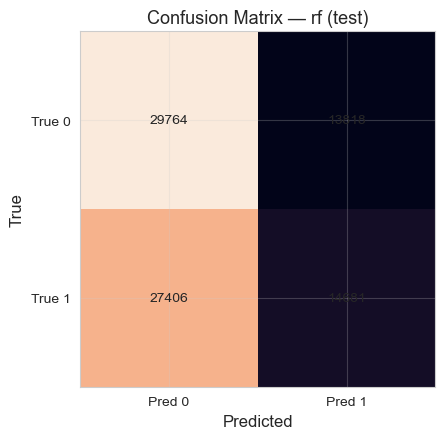

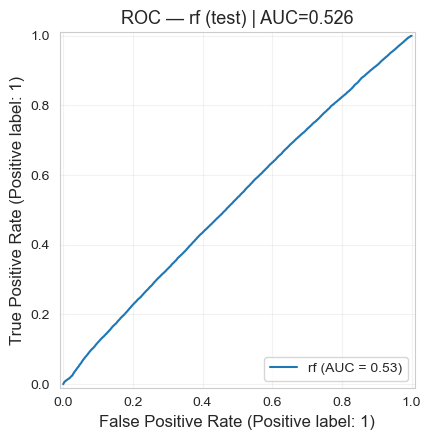

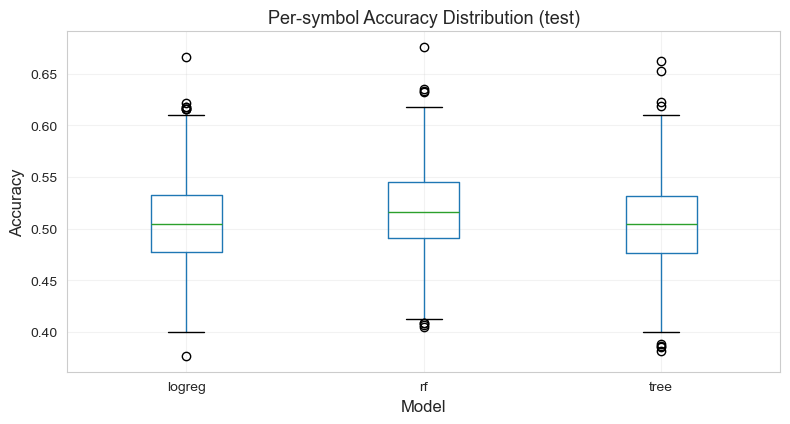

18:20:56 | INFO     | TABLE: Regression — Final test metrics | rows=2 cols=5


,model,mae,rmse,r2,n_obs_test
0,rf,0.001025,0.004690,0.022813,85208
1,ridge,0.001029,0.004745,0.000078,85208


18:20:56 | INFO     | Best regression model: rf (MAE=0.001025, RMSE=0.004690, R2=0.0228)


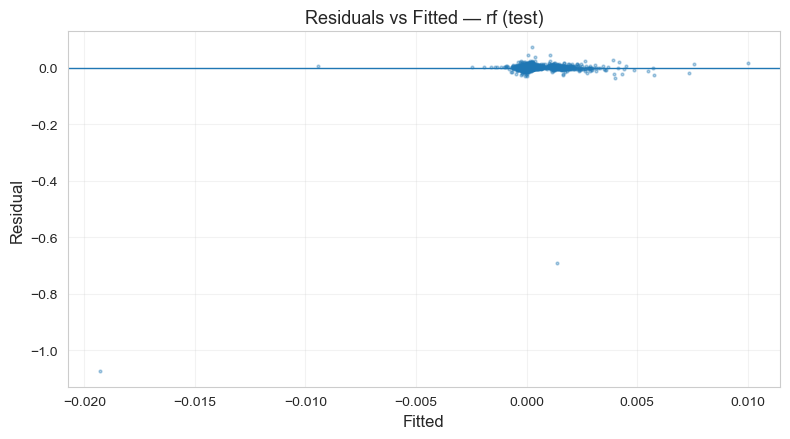

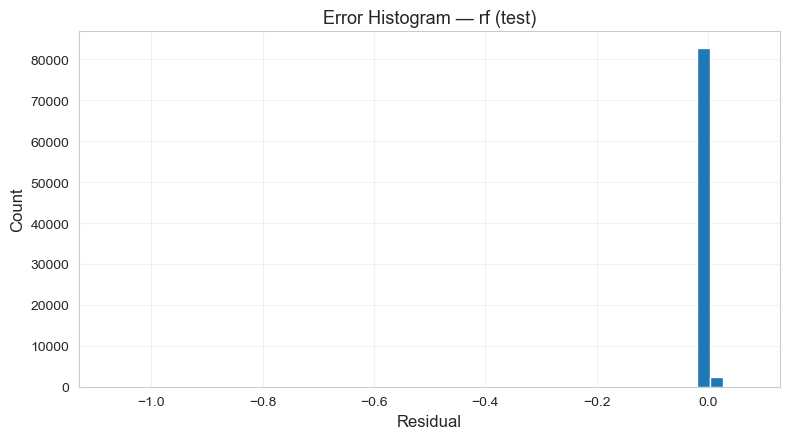

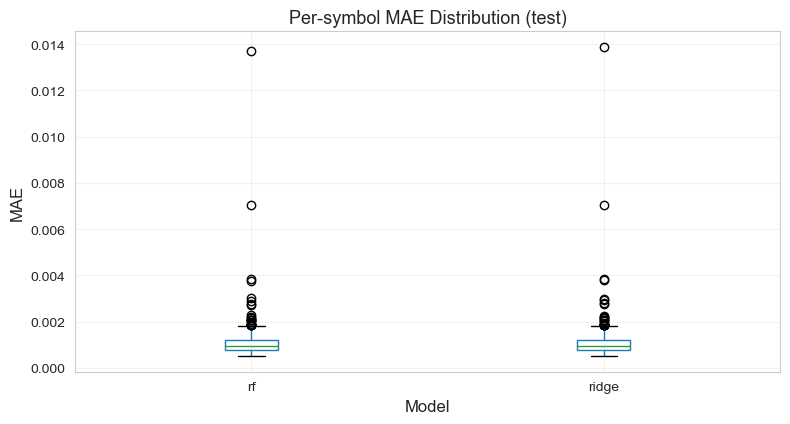

18:20:57 | INFO     | TABLE: Classification — CV summary (mean across folds) | rows=3 cols=6


,model,roc_auc_mean,roc_auc_sd,f1_mean,accuracy_mean,folds
0,logreg,0.504310,0.006570,0.391947,0.505387,11
1,rf,0.513733,0.005791,0.446898,0.509252,11
2,tree,0.509232,0.006054,0.401223,0.505950,11


18:20:57 | INFO     | TABLE: Regression — CV summary (mean across folds) | rows=2 cols=5


,model,mae_mean,rmse_mean,r2_mean,folds
0,ridge,0.001235,0.002246,-0.003510,11
1,rf,0.001242,0.002265,-0.022274,11


18:20:57 | INFO     | TABLE: Best hyperparameters | rows=2 cols=3


,task,file,params
0,classification,week7_cls_best_params.json,"{'logreg': {'C': 1.0}, 'rf': {'n_estimators': ..."
1,regression,week7_reg_best_params.json,"{'ridge': {'alpha': 10.0}, 'rf': {'n_estimator..."


18:20:57 | INFO     | Report rendering complete.


In [63]:
render_full_report()